In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import datetime
import re, struct, pickle
import scapy


from typing import Dict

import warnings

In [2]:
seed_value = 36

import os
os.environ['PYTHONHASHSEED'] = str(seed_value)

import random
random.seed(seed_value)

import numpy as np
np.random.seed(seed_value)

import tensorflow as tf
tf.random.set_seed(seed_value)

2022-09-14 12:59:56.347595: W tensorflow/stream_executor/platform/default/dso_loader.cc:59] Could not load dynamic library 'libcudart.so.10.1'; dlerror: libcudart.so.10.1: cannot open shared object file: No such file or directory
2022-09-14 12:59:56.347632: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
/home/askorohodov/.local/lib/python3.7/site-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.12) or chardet (5.0.0) doesn't match a supported version!
  RequestsDependencyWarning)


In [3]:
from src.preprocessing import prepare_data, get_traintest
from src.processing import Predictor
from src.visualization import plot_result
from src.models.simple_models import OCSVM, LOF, iForest
from src.models.ae_lstm import AE_LSTM
from src.models.som import SOM

In [4]:
model_store_path = './saved_models/'

In [5]:
#pd.set_option('display.max_rows', 150)

# Загрузка данных

In [6]:
with open('/opt/notebooks/cerebrum/CISS2022/ARPE/splitted_payload_192_168_1_50_hex_version.pkl', 'rb') as f:
    data = pickle.load(f)

In [7]:
data

path        id  \
0      /opt/datasets/cerebrum/SWAT/SWaT.A6_Dec 2019/D...      1437   
1      /opt/datasets/cerebrum/SWAT/SWaT.A6_Dec 2019/D...      1439   
2      /opt/datasets/cerebrum/SWAT/SWaT.A6_Dec 2019/D...      4145   
3      /opt/datasets/cerebrum/SWAT/SWaT.A6_Dec 2019/D...      4148   
4      /opt/datasets/cerebrum/SWAT/SWaT.A6_Dec 2019/D...     15407   
...                                                  ...       ...   
84467  /opt/datasets/cerebrum/SWAT/SWaT.A6_Dec 2019/D...  21903527   
84468  /opt/datasets/cerebrum/SWAT/SWaT.A6_Dec 2019/D...  21916030   
84469  /opt/datasets/cerebrum/SWAT/SWaT.A6_Dec 2019/D...  21916031   
84470  /opt/datasets/cerebrum/SWAT/SWaT.A6_Dec 2019/D...  21928124   
84471  /opt/datasets/cerebrum/SWAT/SWaT.A6_Dec 2019/D...  21928128   

             connection_id          timestamp  \
0      b'\x80\x00\xfe\x94'  1575597904.428225   
1      b'\x80\x00\xfe\x94'  1575597904.428227   
2      b'\x80\x00\xfe\x94'  1575597904.544398   
3      b'\x80\x00\xfe\x94'  1575597904.544401   
4      b'\x80\x00\xfe\x94'  1575597904.934351   
...                    ...                ...   
84467  b'\x80\x00\xfe\x94'  1575611102.818197   
84468  b'\x80\x00\xfe\x94'  1575611103.304543   
84469  b'\x80\x00\xfe\x94'  1575611103.304544   
84470  b'\x80\x00\xfe\x94'  1575611103.810903   
84471  b'\x80\x00\xfe\x94'  1575611103.811031   

                                                raw_data  len  \
0      b'\x00CLg<\x00\x01\x00\x00\x00\x00\x00\x00\x00...  343   
1      b'\x00CLg<\x00\x01\x00\x00\x00\x00\x00\x00\x00...  343   
2      b'\x00CLg<\x00\x01\x00\x00\x00\x00\x00\x00\x00...  343   
3      b'\x00CLg<\x00\x01\x00\x00\x00\x00\x00\x00\x00...  343   
4      b'\x00CLg<\x00\x01\x00\x00\x00\x00\x00\x00\x00...  343   
...                                                  ...  ...   
84467  b'\x00CJj\xa7\x00\x01\x00\x00\x00\x00\x00\x00\...  343   
84468  b'\x00CJj\xa7\x00\x01\x00\x00\x00\x00\x00\x00\...  343   
84469  b'\x00CJj\xa7\x00\x01\x00\x00\x00\x00\x00\x00\...  343   
84470  b'\x00CJj\xa7\x00\x01\x00\x00\x00\x00\x00\x00\...  343   
84471  b'\x00CJj\xa7\x00\x01\x00\x00\x00\x00\x00\x00\...  343   

                                                int_data   0   1   2  ... 189  \
0      (0, 67, 76, 103, 60, 0, 1, 0, 0, 0, 0, 0, 0, 0...  67  3c  00  ...  00   
1      (0, 67, 76, 103, 60, 0, 1, 0, 0, 0, 0, 0, 0, 0...  67  3c  00  ...  00   
2      (0, 67, 76, 103, 60, 0, 1, 0, 0, 0, 0, 0, 0, 0...  67  3c  00  ...  00   
3      (0, 67, 76, 103, 60, 0, 1, 0, 0, 0, 0, 0, 0, 0...  67  3c  00  ...  00   
4      (0, 67, 76, 103, 60, 0, 1, 0, 0, 0, 0, 0, 0, 0...  67  3c  00  ...  00   
...                                                  ...  ..  ..  ..  ...  ..   
84467  (0, 67, 74, 106, 167, 0, 1, 0, 0, 0, 0, 0, 0, ...  6a  a7  00  ...  00   
84468  (0, 67, 74, 106, 167, 0, 1, 0, 0, 0, 0, 0, 0, ...  6a  a7  00  ...  00   
84469  (0, 67, 74, 106, 167, 0, 1, 0, 0, 0, 0, 0, 0, ...  6a  a7  00  ...  00   
84470  (0, 67, 74, 106, 167, 0, 1, 0, 0, 0, 0, 0, 0, ...  6a  a7  00  ...  00   
84471  (0, 67, 74, 106, 167, 0, 1, 0, 0, 0, 0, 0, 0, ...  6a  a7  00  ...  00   

        190   191   192 193 194   195   196 197     198  
0      0000  40e0  fea0  23  00  0100  0000  cc  cc7d86  
1      0000  40e0  fea0  23  00  0100  0000  cc  cc7d86  
2      0000  40e0  fea0  23  00  0100  0000  cc  cc7d87  
3      0000  40e0  fea0  23  00  0100  0000  cc  cc7d87  
4      0000  40e0  fea0  23  00  0100  0000  cc  cc7d88  
...     ...   ...   ...  ..  ..   ...   ...  ..     ...  
84467  0000  40e5  189c  23  00  0100  0000  cc  cc2a69  
84468  0000  40e5  1ddc  23  00  0100  0000  cc  cc2a6a  
84469  0000  40e5  1ddc  23  00  0100  0000  cc  cc2a6a  
84470  0000  40e5  1ddc  23  00  0100  0000  cc  cc2a6b  
84471  0000  40e5  1ddc  23  00  0100  0000  cc  cc2a6b  

[84472 rows x 206 columns]

In [8]:
data.index = pd.to_datetime(data['timestamp'].astype(float), unit='s')

In [9]:
data['path'] = data['path'].apply(lambda x: x[74:77])
data.drop('timestamp', axis=1, inplace=True)

In [10]:
data

path        id        connection_id  \
timestamp                                                           
2019-12-06 02:05:04.428225040  015      1437  b'\x80\x00\xfe\x94'   
2019-12-06 02:05:04.428226948  015      1439  b'\x80\x00\xfe\x94'   
2019-12-06 02:05:04.544398069  015      4145  b'\x80\x00\xfe\x94'   
2019-12-06 02:05:04.544400930  015      4148  b'\x80\x00\xfe\x94'   
2019-12-06 02:05:04.934350967  015     15407  b'\x80\x00\xfe\x94'   
...                            ...       ...                  ...   
2019-12-06 05:45:02.818197012  011  21903527  b'\x80\x00\xfe\x94'   
2019-12-06 05:45:03.304543018  011  21916030  b'\x80\x00\xfe\x94'   
2019-12-06 05:45:03.304543972  011  21916031  b'\x80\x00\xfe\x94'   
2019-12-06 05:45:03.810903072  011  21928124  b'\x80\x00\xfe\x94'   
2019-12-06 05:45:03.811031103  011  21928128  b'\x80\x00\xfe\x94'   

                                                                        raw_data  \
timestamp                                                                          
2019-12-06 02:05:04.428225040  b'\x00CLg<\x00\x01\x00\x00\x00\x00\x00\x00\x00...   
2019-12-06 02:05:04.428226948  b'\x00CLg<\x00\x01\x00\x00\x00\x00\x00\x00\x00...   
2019-12-06 02:05:04.544398069  b'\x00CLg<\x00\x01\x00\x00\x00\x00\x00\x00\x00...   
2019-12-06 02:05:04.544400930  b'\x00CLg<\x00\x01\x00\x00\x00\x00\x00\x00\x00...   
2019-12-06 02:05:04.934350967  b'\x00CLg<\x00\x01\x00\x00\x00\x00\x00\x00\x00...   
...                                                                          ...   
2019-12-06 05:45:02.818197012  b'\x00CJj\xa7\x00\x01\x00\x00\x00\x00\x00\x00\...   
2019-12-06 05:45:03.304543018  b'\x00CJj\xa7\x00\x01\x00\x00\x00\x00\x00\x00\...   
2019-12-06 05:45:03.304543972  b'\x00CJj\xa7\x00\x01\x00\x00\x00\x00\x00\x00\...   
2019-12-06 05:45:03.810903072  b'\x00CJj\xa7\x00\x01\x00\x00\x00\x00\x00\x00\...   
2019-12-06 05:45:03.811031103  b'\x00CJj\xa7\x00\x01\x00\x00\x00\x00\x00\x00\...   

                               len  \
timestamp                            
2019-12-06 02:05:04.428225040  343   
2019-12-06 02:05:04.428226948  343   
2019-12-06 02:05:04.544398069  343   
2019-12-06 02:05:04.544400930  343   
2019-12-06 02:05:04.934350967  343   
...                            ...   
2019-12-06 05:45:02.818197012  343   
2019-12-06 05:45:03.304543018  343   
2019-12-06 05:45:03.304543972  343   
2019-12-06 05:45:03.810903072  343   
2019-12-06 05:45:03.811031103  343   

                                                                        int_data  \
timestamp                                                                          
2019-12-06 02:05:04.428225040  (0, 67, 76, 103, 60, 0, 1, 0, 0, 0, 0, 0, 0, 0...   
2019-12-06 02:05:04.428226948  (0, 67, 76, 103, 60, 0, 1, 0, 0, 0, 0, 0, 0, 0...   
2019-12-06 02:05:04.544398069  (0, 67, 76, 103, 60, 0, 1, 0, 0, 0, 0, 0, 0, 0...   
2019-12-06 02:05:04.544400930  (0, 67, 76, 103, 60, 0, 1, 0, 0, 0, 0, 0, 0, 0...   
2019-12-06 02:05:04.934350967  (0, 67, 76, 103, 60, 0, 1, 0, 0, 0, 0, 0, 0, 0...   
...                                                                          ...   
2019-12-06 05:45:02.818197012  (0, 67, 74, 106, 167, 0, 1, 0, 0, 0, 0, 0, 0, ...   
2019-12-06 05:45:03.304543018  (0, 67, 74, 106, 167, 0, 1, 0, 0, 0, 0, 0, 0, ...   
2019-12-06 05:45:03.304543972  (0, 67, 74, 106, 167, 0, 1, 0, 0, 0, 0, 0, 0, ...   
2019-12-06 05:45:03.810903072  (0, 67, 74, 106, 167, 0, 1, 0, 0, 0, 0, 0, 0, ...   
2019-12-06 05:45:03.811031103  (0, 67, 74, 106, 167, 0, 1, 0, 0, 0, 0, 0, 0, ...   

                                0   1   2   3  ... 189   190   191   192 193  \
timestamp                                      ...                             
2019-12-06 02:05:04.428225040  67  3c  00  01  ...  00  0000  40e0  fea0  23   
2019-12-06 02:05:04.428226948  67  3c  00  01  ...  00  0000  40e0  fea0  23   
2019-12-06 02:05:04.544398069  67  3c  00  01  ...  00  0000  40e0  fea0  23   
2019-12-06 02:05:04.544400930  67  3c  00  01  ... 

### Работаем с byte

In [11]:
df_bytes = data.copy().drop(['path', 'connection_id', 'raw_data', 'len', 'int_data'], axis=1)

In [12]:
df_bytes

id   0   1   2   3   4     5     6     7  \
timestamp                                                                       
2019-12-06 02:05:04.428225040      1437  67  3c  00  01  00  0000  0000  0000   
2019-12-06 02:05:04.428226948      1439  67  3c  00  01  00  0000  0000  0000   
2019-12-06 02:05:04.544398069      4145  67  3c  00  01  00  0000  0000  0000   
2019-12-06 02:05:04.544400930      4148  67  3c  00  01  00  0000  0000  0000   
2019-12-06 02:05:04.934350967     15407  67  3c  00  01  00  0000  0000  0000   
...                                 ...  ..  ..  ..  ..  ..   ...   ...   ...   
2019-12-06 05:45:02.818197012  21903527  6a  a7  00  01  00  0000  0000  0000   
2019-12-06 05:45:03.304543018  21916030  6a  a7  00  01  00  0000  0000  0000   
2019-12-06 05:45:03.304543972  21916031  6a  a7  00  01  00  0000  0000  0000   
2019-12-06 05:45:03.810903072  21928124  6a  a7  00  01  00  0000  0000  0000   
2019-12-06 05:45:03.811031103  21928128  6a  a7  00  01  00  0000  0000  0000   

                                  8  ... 189   190   191   192 193 194   195  \
timestamp                            ...                                       
2019-12-06 02:05:04.428225040  0000  ...  00  0000  40e0  fea0  23  00  0100   
2019-12-06 02:05:04.428226948  0000  ...  00  0000  40e0  fea0  23  00  0100   
2019-12-06 02:05:04.544398069  0000  ...  00  0000  40e0  fea0  23  00  0100   
2019-12-06 02:05:04.544400930  0000  ...  00  0000  40e0  fea0  23  00  0100   
2019-12-06 02:05:04.934350967  0000  ...  00  0000  40e0  fea0  23  00  0100   
...                             ...  ...  ..   ...   ...   ...  ..  ..   ...   
2019-12-06 05:45:02.818197012  0000  ...  00  0000  40e5  189c  23  00  0100   
2019-12-06 05:45:03.304543018  0000  ...  00  0000  40e5  1ddc  23  00  0100   
2019-12-06 05:45:03.304543972  0000  ...  00  0000  40e5  1ddc  23  00  0100   
2019-12-06 05:45:03.810903072  0000  ...  00  0000  40e5  1ddc  23  00  0100   
2019-12-06 05:45:03.811031103  0000  ...  00  0000  40e5  1ddc  23  00  0100   

                                196 197     198  
timestamp                                        
2019-12-06 02:05:04.428225040  0000  cc  cc7d86  
2019-12-06 02:05:04.428226948  0000  cc  cc7d86  
2019-12-06 02:05:04.544398069  0000  cc  cc7d87  
2019-12-06 02:05:04.544400930  0000  cc  cc7d87  
2019-12-06 02:05:04.934350967  0000  cc  cc7d88  
...                             ...  ..     ...  
2019-12-06 05:45:02.818197012  0000  cc  cc2a69  
2019-12-06 05:45:03.304543018  0000  cc  cc2a6a  
2019-12-06 05:45:03.304543972  0000  cc  cc2a6a  
2019-12-06 05:45:03.810903072  0000  cc  cc2a6b  
2019-12-06 05:45:03.811031103  0000  cc  cc2a6b  

[84472 rows x 200 columns]

In [13]:
df_bytes = df_bytes[~df_bytes.index.duplicated(keep='first')].sort_index()

In [14]:
def count_bytes_len(value):   
    return len(value)//2

def convert_bytes(string_hex):
    
    try:
        return struct.unpack('H', bytes.fromhex(str(string_hex)))[0]
            
    except Exception as err:
        print(err, string_hex)
        return None
        
        

In [16]:
df_bytes_ = df_bytes.drop('id', axis=1)
df_bytes_len = df_bytes_.applymap(count_bytes_len)
not_byte_columns = []
constant_columns = []

for col in df_bytes_len.columns:
    col_unique_values = df_bytes_len[col].unique()
    if col_unique_values.shape[0]==1 and col_unique_values[0]==1:
        not_byte_columns.append(col)
        
print('not bytes:', not_byte_columns, 'lenght:', len(not_byte_columns))

for col in df_bytes_len.drop(not_byte_columns, axis=1).columns:
    col_unique_values = df_bytes_[col].unique()
    if col_unique_values.shape[0]==1:
        constant_columns.append(col)

print('constant:', constant_columns, 'lenght:', len(constant_columns))

df_bytes_ = df_bytes_.drop(constant_columns+not_byte_columns, axis=1)  

not bytes: [0, 1, 2, 3, 4, 10, 11, 17, 18, 19, 20, 21, 27, 28, 33, 34, 42, 43, 45, 46, 53, 54, 60, 62, 63, 69, 70, 73, 74, 104, 105, 114, 115, 121, 122, 123, 124, 130, 131, 138, 139, 142, 144, 145, 152, 155, 156, 165, 166, 167, 168, 177, 178, 179, 180, 181, 186, 187, 188, 189, 193, 194, 197] lenght: 63
constant: [5, 6, 7, 8, 9, 12, 13, 14, 15, 22, 23, 24, 25, 26, 29, 32, 35, 36, 37, 38, 39, 40, 41, 47, 48, 49, 50, 51, 52, 55, 56, 57, 58, 59, 64, 65, 66, 67, 68, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 106, 107, 108, 109, 110, 111, 118, 119, 120, 125, 126, 127, 134, 135, 136, 137, 140, 141, 146, 147, 148, 149, 150, 151, 157, 158, 159, 160, 161, 162, 169, 170, 171, 172, 173, 174, 175, 182, 183, 184, 185, 190, 195, 196] lenght: 110


In [17]:
df_bytes_

16    30    31    44    61    71    72   \
timestamp                                                                   
2019-12-06 02:05:04.428225040  004342  4058  51f3  7f00  bdde  0000  0000   
2019-12-06 02:05:04.428226948  004342  4058  51f3  7f00  bdde  0000  0000   
2019-12-06 02:05:04.544398069  004342  4058  51f3  7f00  bdde  0000  0000   
2019-12-06 02:05:04.544400930  004342  4058  51f3  7f00  bdde  0000  0000   
2019-12-06 02:05:04.934350967  004342  4058  51f3  7f00  bdde  0000  0000   
...                               ...   ...   ...   ...   ...   ...   ...   
2019-12-06 05:45:02.818197012  004340  405a  5edc  4d00  9111  0000  0000   
2019-12-06 05:45:03.304543018  004340  405a  5edc  4d00  9111  0000  0000   
2019-12-06 05:45:03.304543972  004340  405a  5edc  4d00  9111  0000  0000   
2019-12-06 05:45:03.810903072  004340  405a  5edc  4d00  9111  0000  0000   
2019-12-06 05:45:03.811031103  004340  405a  5edc  4d00  9111  0000  0000   

                                102   103   112  ...       133   143   153  \
timestamp                                        ...                         
2019-12-06 02:05:04.428225040  4254  3fd4  3de8  ...  f8000000  b0dc  1d7f   
2019-12-06 02:05:04.428226948  4254  3fd4  3de8  ...  f8000000  b0dc  1d7f   
2019-12-06 02:05:04.544398069  4254  3fd4  3de8  ...  f8000000  b0dc  1d7f   
2019-12-06 02:05:04.544400930  4254  3fd4  3de8  ...  f8000000  b0dc  1d7f   
2019-12-06 02:05:04.934350967  4254  3fd4  3de8  ...  f8000000  b0dc  1d7f   
...                             ...   ...   ...  ...       ...   ...   ...   
2019-12-06 05:45:02.818197012  4255  d6dc  3de4  ...  4c000000  f040  f617   
2019-12-06 05:45:03.304543018  4255  d6e4  3de4  ...  59000000  f040  f617   
2019-12-06 05:45:03.304543972  4255  d6e4  3de4  ...  59000000  f040  f617   
2019-12-06 05:45:03.810903072  4255  d6e4  3de4  ...  59000000  f040  f617   
2019-12-06 05:45:03.811031103  4255  d6e4  3de4  ...  59000000  f040  f617   

                                154     163   164   176   191   192     198  
timestamp                                                                    
2019-12-06 02:05:04.428225040  8220  000041  e9c9  433e  40e0  fea0  cc7d86  
2019-12-06 02:05:04.428226948  8220  000041  e9c9  433e  40e0  fea0  cc7d86  
2019-12-06 02:05:04.544398069  8220  000041  e9c9  433e  40e0  fea0  cc7d87  
2019-12-06 02:05:04.544400930  8220  000041  e9c9  433e  40e0  fea0  cc7d87  
2019-12-06 02:05:04.934350967  8220  000041  e9c9  433e  40e0  fea0  cc7d88  
...                             ...     ...   ...   ...   ...   ...     ...  
2019-12-06 05:45:02.818197012  3b20  000042  39b8  434f  40e5  189c  cc2a69  
2019-12-06 05:45:03.304543018  3b20  000042  39b8  434f  40e5  1ddc  cc2a6a  
2019-12-06 05:45:03.304543972  3b20  000042  39b8  434f  40e5  1ddc  cc2a6a  
2019-12-06 05:45:03.810903072  3b20  000042  39b8  434f  40e5  1ddc  cc2a6b  
2019-12-06 05:45:03.811031103  3b20  000042  39b8  434f  40e5  1ddc  cc2a6b  

[83719 rows x 26 columns]

In [19]:
for col in df_bytes_.columns:
    display(df_bytes_[col].value_counts())

004342    44702
004341    25661
004340    13288
004343       68
Name: 16, dtype: int64

405a    26648
405b    24779
4058    11957
405c     8537
4057     3041
405d     2506
405f     1949
4056     1397
4060      993
4061      488
4055      470
4062      466
4053      138
4064      119
4065       76
4066       65
4052       60
4051       22
4050        8
Name: 30, dtype: int64

5edc    26648
6551    24779
51f3    11957
6bc5     8537
4b7f     3041
7239     2506
7f22     1949
450b     1397
8597      993
8c0b      488
3e96      470
9280      466
31ad      138
9f68      119
a5dd       76
ac51       65
2b39       60
24c4       22
1e50        8
Name: 31, dtype: int64

fd00    4749
3100    3996
4b00    3356
3500    3123
6c00    2855
        ... 
f600       4
cb00       2
aa00       2
ae00       2
7d00       2
Name: 44, Length: 147, dtype: int64

1777    840
5111    838
8ccd    837
d555    836
caab    835
       ... 
a889    373
b333    366
9555    360
a000    355
bbbc    355
Name: 61, Length: 120, dtype: int64

0000    83705
3c88       14
Name: 71, dtype: int64

0000    83705
8889       14
Name: 72, dtype: int64

4255    46270
4254    37449
Name: 102, dtype: int64

767c    20
be0c    18
7364    18
a104    18
7f6c    18
        ..
04a4     4
69dc     3
1544     3
1854     3
0c9c     3
Name: 103, Length: 8192, dtype: int64

3de7    45081
3de3    11062
3de8     8589
3de2     7008
3de6     5727
3de4     2967
3de5     1365
3de9      801
3dea      720
3de1      199
3deb      122
3de0       46
3dde       26
3ddf        6
Name: 112, dtype: int64

8668    19059
c987    14956
4348    11066
0ca7     5584
546c     4648
978c     3670
bd08     3640
ce2d     3511
daac     2744
92e7     2152
8b0d     1804
1dcb     1622
79e9     1368
47ed     1288
d606      853
a40b      762
36c9      719
e72a      583
f3a9      547
2a4a      444
04ce      405
6d6a      374
25a5      336
1926      304
5c46      273
68c5      268
e285      224
7e8e      149
abe4      116
3224       80
3b6e       50
7543       28
5912       26
f84f       26
b52f       20
b863       14
ebd0        2
a8b0        2
6590        2
Name: 113, dtype: int64

43a7    40091
43a6    21939
43a8    21689
Name: 116, dtype: int64

0990    16
dd90    10
0888    10
4bcb    10
e50a    10
        ..
9f21     3
74a4     3
d902     3
808b     3
8ad7     2
Name: 117, Length: 12430, dtype: int64

3f9cd6    1812
3f9cd2    1385
3f9cdb    1331
3f9b8b    1249
3f9ce3    1234
          ... 
3f9750       2
3f976d       2
3fa2e7       2
3fa155       2
3fa1fc       2
Name: 128, Length: 558, dtype: int64

fb04    2118
6504    1539
ca04    1526
9604    1482
c804    1435
        ... 
7104      22
8604      14
7f04      12
3204       6
7804       2
Name: 129, Length: 235, dtype: int64

e0f4    158
e19a    158
e0e8    158
e1f3    158
e0e5    158
       ... 
e311     97
e101     96
e104     87
e346     34
e0da      8
Name: 132, Length: 594, dtype: int64

d3000000    477
33000000    475
9b000000    475
a7000000    472
cf000000    471
           ... 
dd000000    197
ad000000    191
71000000    188
de000000    187
ea000000    183
Name: 133, Length: 256, dtype: int64

93da    1960
a074    1675
9c40    1620
980d    1610
6174    1558
        ... 
8f10       2
dedc       2
6d76       2
6510       2
9776       2
Name: 143, Length: 202, dtype: int64

f617    12166
f12b     8720
fb03     6399
026d     5725
ec3f     4543
0759     4401
4eb7     3555
04e3     3491
ac43     3345
1d7f     3297
a757     3191
e267     3061
d88f     2842
89cf     1596
d3a3     1521
9893     1501
dd7b     1493
bff3     1230
b12f     1142
8ebb     1060
c4df      998
c9cb      994
44df      873
93a7      797
13a7      793
a26b      700
312f      635
09cf      633
6267      606
7fef      550
1131      398
0ebb      393
bb07      353
3b07      258
7617      199
ffef      120
6c3f       86
161d       42
1ff5       12
Name: 153, dtype: int64

3b20    12365
3f20     8720
3720     6399
9820     5725
4320     4629
9420     4401
4b20     3667
5b20     3555
9620     3491
7620     3345
8220     3297
7a20     3191
5320     2842
9220     2229
6220     1871
7220     1777
8a20     1590
5720     1521
8620     1501
4f20     1493
8e20     1453
6620     1230
5f20      994
7e20      700
3320      670
6a20      611
8c20      398
8820       42
8020       12
Name: 154, dtype: int64

000042    75105
000041     8614
Name: 163, dtype: int64

3cab    4741
3477    3968
3b63    2198
1ad5    2119
3956    2070
        ... 
10f6       2
2702       2
05af       2
148d       2
144b       2
Name: 164, Length: 321, dtype: int64

434d    16562
434b    13769
434e     9019
434c     8572
4346     4669
4343     4590
434f     4436
4345     4151
4342     2927
4348     2196
433d     2128
434a     1770
4340     1700
4347     1673
433e     1640
4349     1621
4344     1201
4341      589
433f      492
4350       14
Name: 176, dtype: int64

40e3    37193
40e2    23411
40e4    16453
40e1     5435
40e0      842
40e5      385
Name: 191, dtype: int64

10de    879
6cbe    767
c89d    763
5f9e    663
1f3d    647
       ... 
95a0      2
25bc      2
aaa0      2
80a0      2
fbbc      2
Name: 192, Length: 353, dtype: int64

cc915d    4
ccc34d    4
ccc215    4
cce87f    4
ccb585    4
         ..
cc0f59    1
cc0b2d    1
cc0783    1
cc0d47    1
ccee0d    1
Name: 198, Length: 42224, dtype: int64

In [ ]:
for col in [67,80]:
    df_bytes3 = df_bytes_[[col]].copy()
    df_bytes3['byte_1'] = df_bytes3[col].apply(lambda x: x[:2])
    df_bytes3['byte_2'] = df_bytes3[col].apply(lambda x: x[2:4])
    df_bytes3['byte_3'] = df_bytes3[col].apply(lambda x: x[-2:])
    
    print(col)

    for b in ['byte_1','byte_3']:
        display(df_bytes3[b].value_counts())

In [19]:
df_bytes_['67_3'] = df_bytes_[67].apply(lambda x: '00' + str(x[-2:])) 
df_bytes_[67] = df_bytes_[67].apply(lambda x: x[:-2]) 
df_bytes_[80] = df_bytes_[80].apply(lambda x: x[2:]) 

In [20]:
df_bytes_converted = df_bytes_.applymap(convert_bytes)
df_bytes_converted['id'] = df_bytes['id']
df_bytes_converted

7      8  19   21   22   30     32   33  \
timestamp                                                                    
2019-12-06 02:05:04.415631056  59202  48187   1  257  768  512  39273  410   
2019-12-06 02:05:04.415632010  59202  48187   1  257  768  512  39273  410   
2019-12-06 02:05:04.532814026  59202  48187   1  257  768  512  39273  410   
2019-12-06 02:05:04.532814980  59202  48187   1  257  768  512  39273  410   
2019-12-06 02:05:04.913991928  59202  48187   1  257  768  512  39273  410   
...                              ...    ...  ..  ...  ...  ...    ...  ...   
2019-12-06 05:45:02.793700933  60226  57053   1  257  512  512  21895  341   
2019-12-06 05:45:03.292222023  60226  57053   1  257  512  512  21895  341   
2019-12-06 05:45:03.292222977  60226  57053   1  257  512  512  21895  341   
2019-12-06 05:45:03.796188116  60226  57053   1  257  512  512  21895  341   
2019-12-06 05:45:03.796189070  60226  57053   1  257  512  512  21895  341   

                               37    38  ...     41     51     52    53  \
timestamp                                ...                              
2019-12-06 02:05:04.415631056   2  4866  ...  17171  17408  61476  8362   
2019-12-06 02:05:04.415632010   2  4866  ...  17171  17408  61476  8362   
2019-12-06 02:05:04.532814026   2  4866  ...  17171  17408  60196  8355   
2019-12-06 02:05:04.532814980   2  4866  ...  17171  17408  60196  8355   
2019-12-06 02:05:04.913991928   2  4866  ...  17171  17408  63524  8243   
...                            ..   ...  ...    ...    ...    ...   ...   
2019-12-06 05:45:02.793700933   2  4866  ...  17171  17408  16431  8438   
2019-12-06 05:45:03.292222023   2  4866  ...  17171  17408  15151  8432   
2019-12-06 05:45:03.292222977   2  4866  ...  17171  17408  15151  8432   
2019-12-06 05:45:03.796188116   2  4866  ...  17171  17408  12079  8288   
2019-12-06 05:45:03.796189070   2  4866  ...  17171  17408  12079  8288   

                                  56  66  67     80  67_3        id  
timestamp                                                            
2019-12-06 02:05:04.415631056  64828   0   0  49325     0      1107  
2019-12-06 02:05:04.415632010  64828   0   0  49325     0      1108  
2019-12-06 02:05:04.532814026  64828   0   0  49581     0      3873  
2019-12-06 02:05:04.532814980  64828   0   0  49581     0      3874  
2019-12-06 02:05:04.913991928  64828   0   0  49837     0     14933  
...                              ...  ..  ..    ...   ...       ...  
2019-12-06 05:45:02.793700933  17511   0   0  26463     0  21902947  
2019-12-06 05:45:03.292222023  17511   0   0  26719     0  21915746  
2019-12-06 05:45:03.292222977  17511   0   0  26719     0  21915747  
2019-12-06 05:45:03.796188116  17511   0   0  26975     0  21927579  
2019-12-06 05:45:03.796189070  17511   0   0  26975     0  21927580  

[84402 rows x 22 columns]

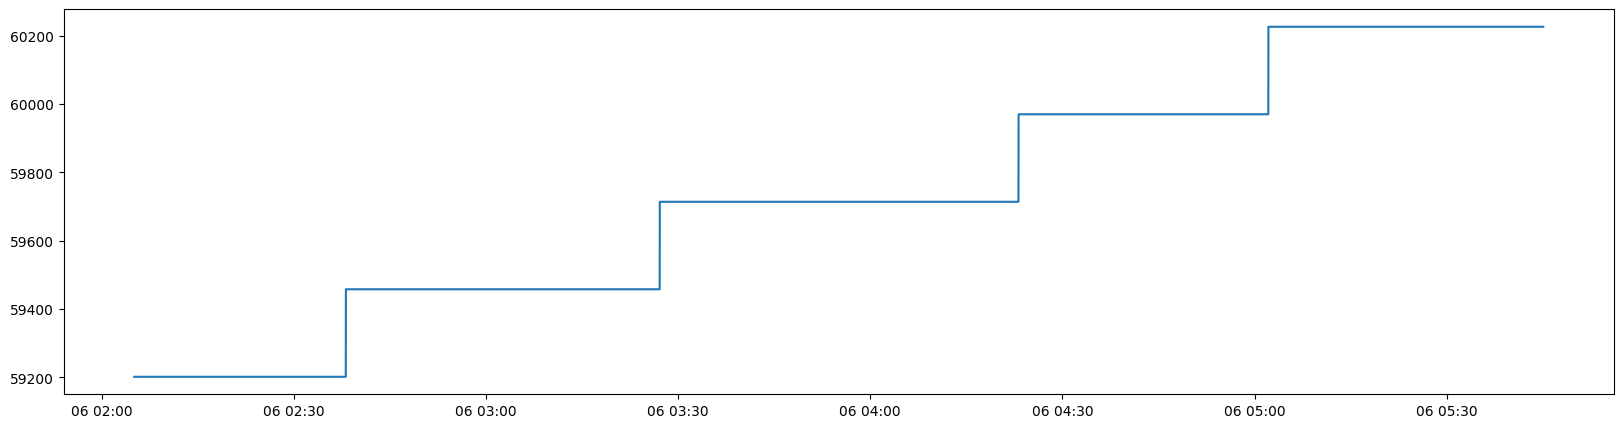

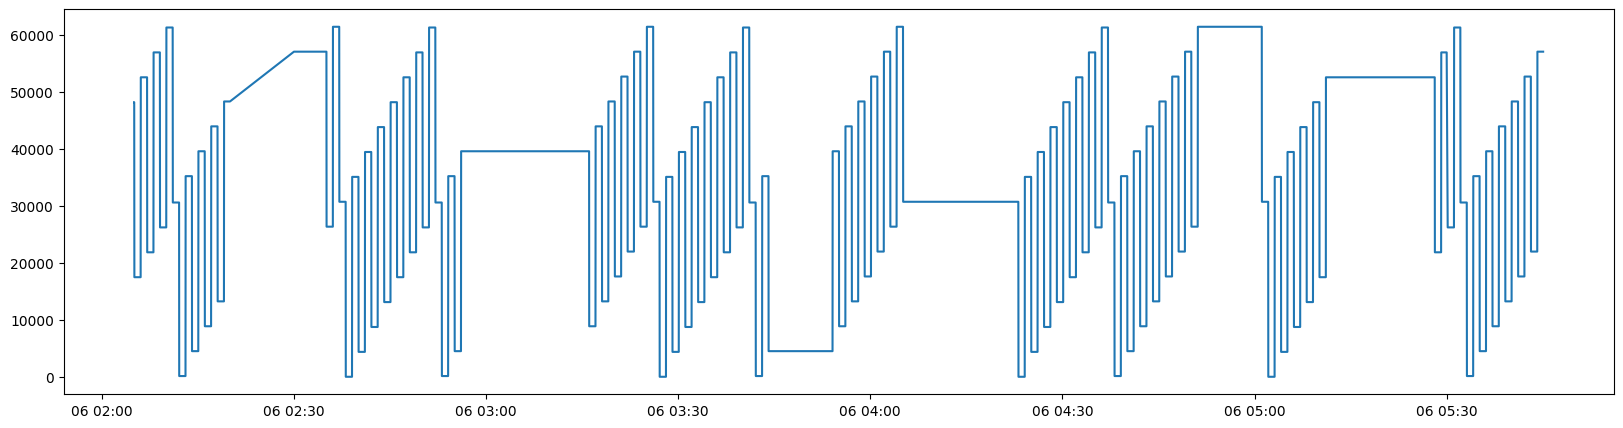

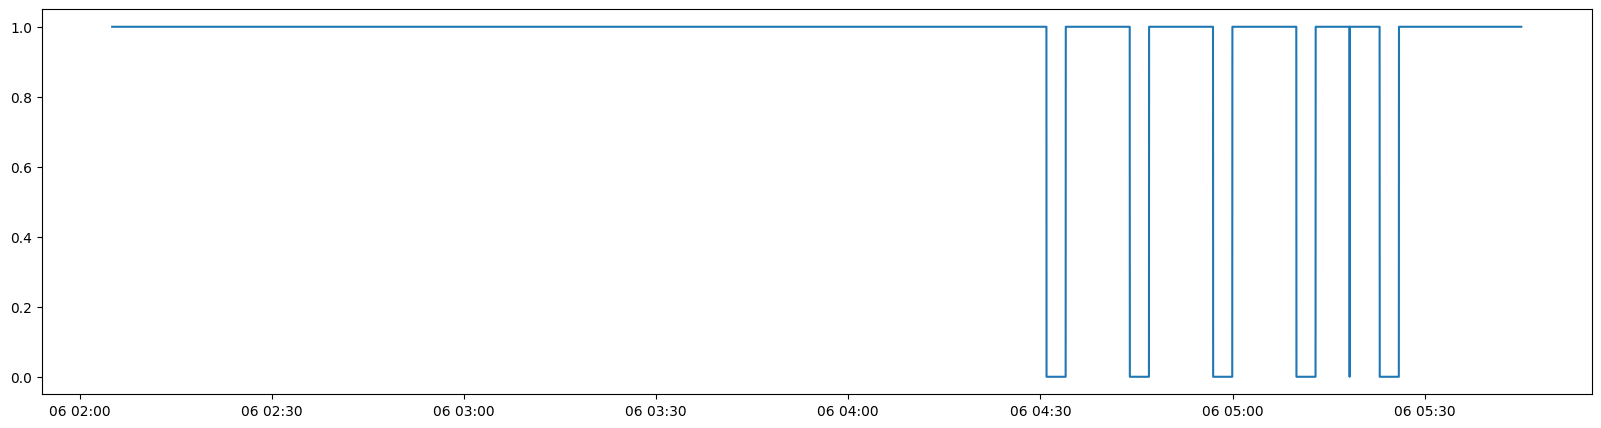

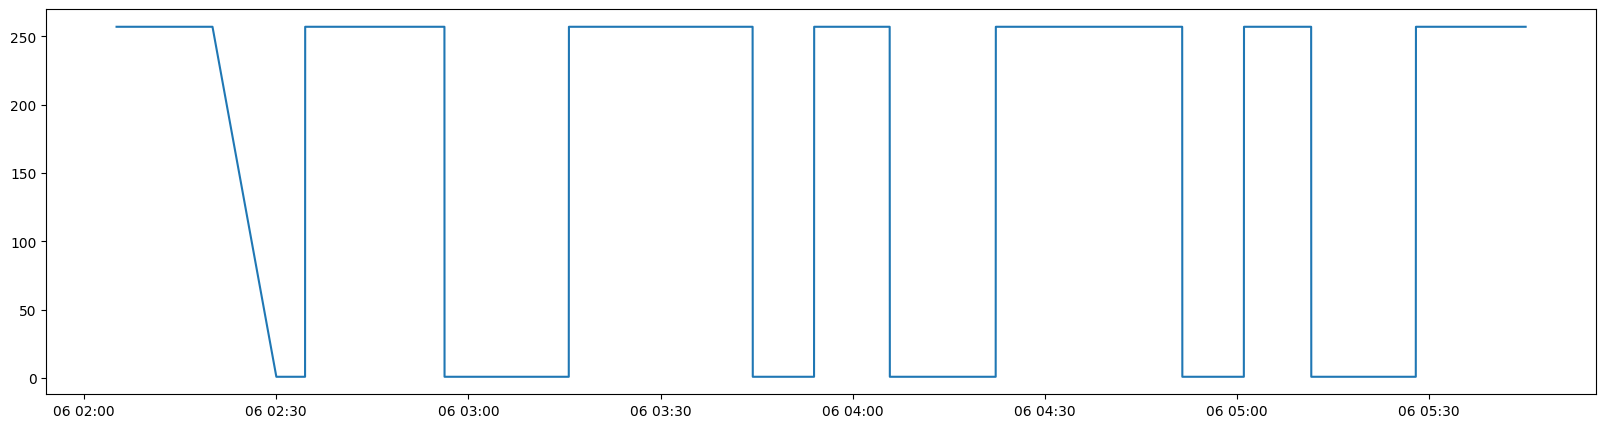

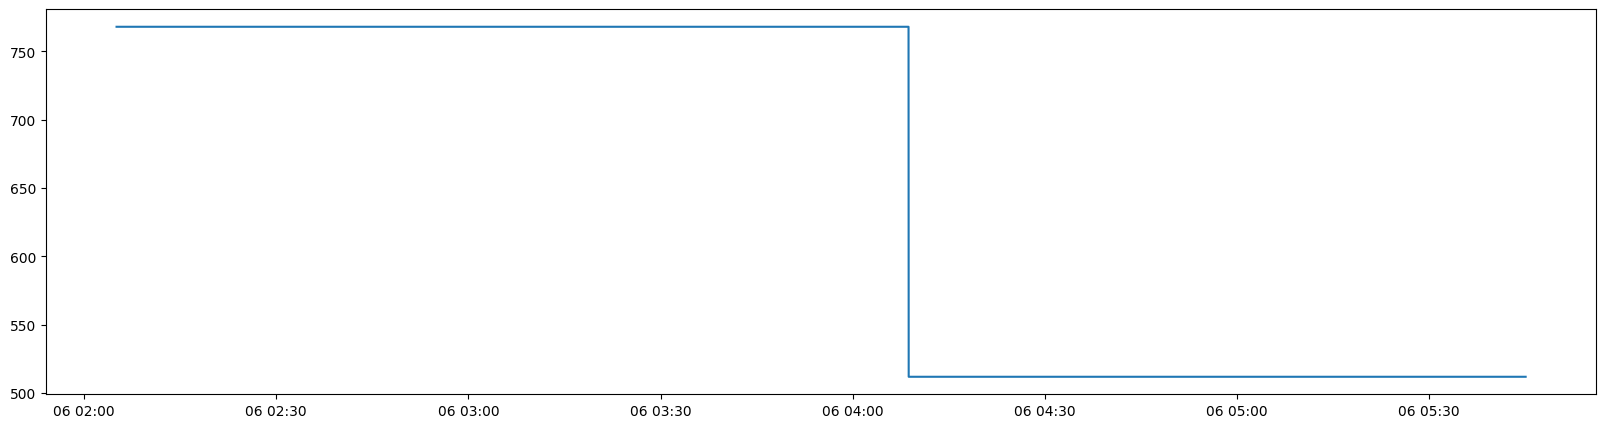

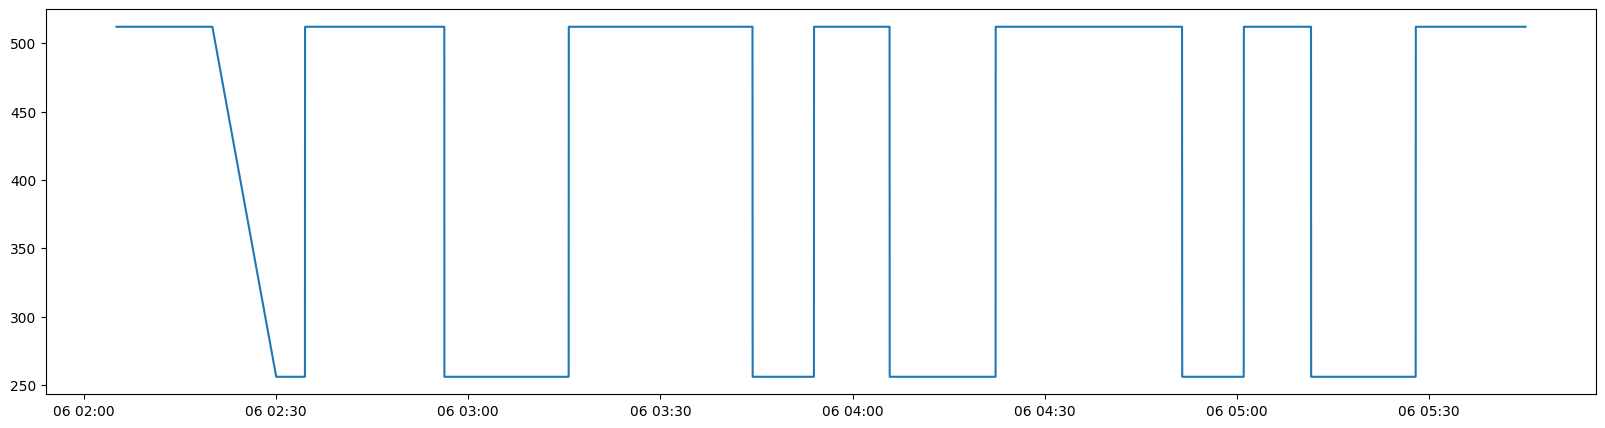

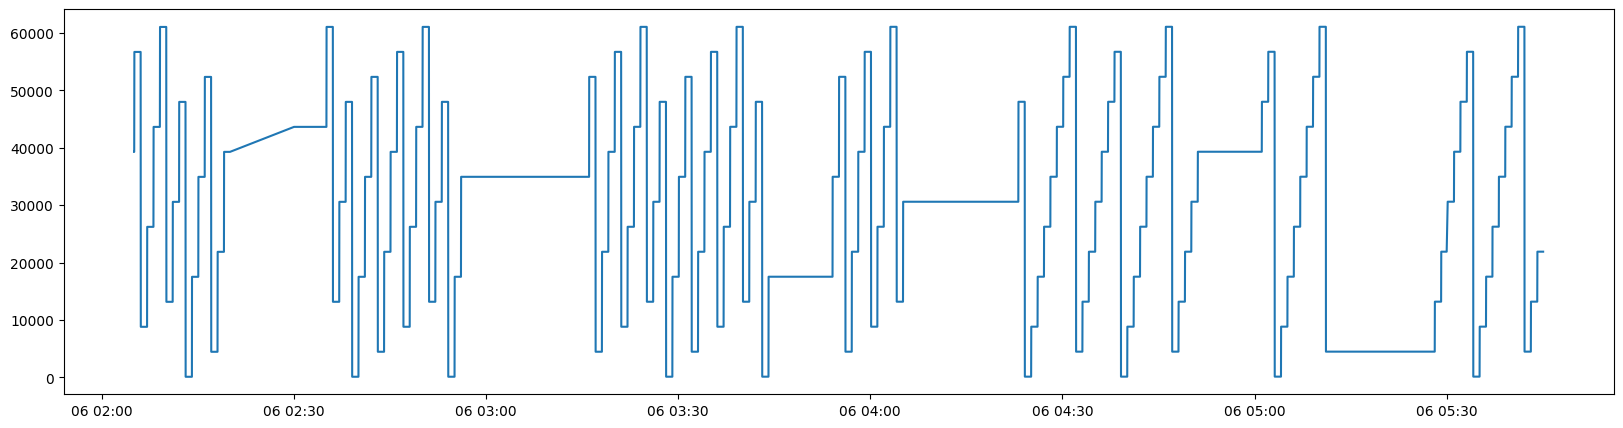

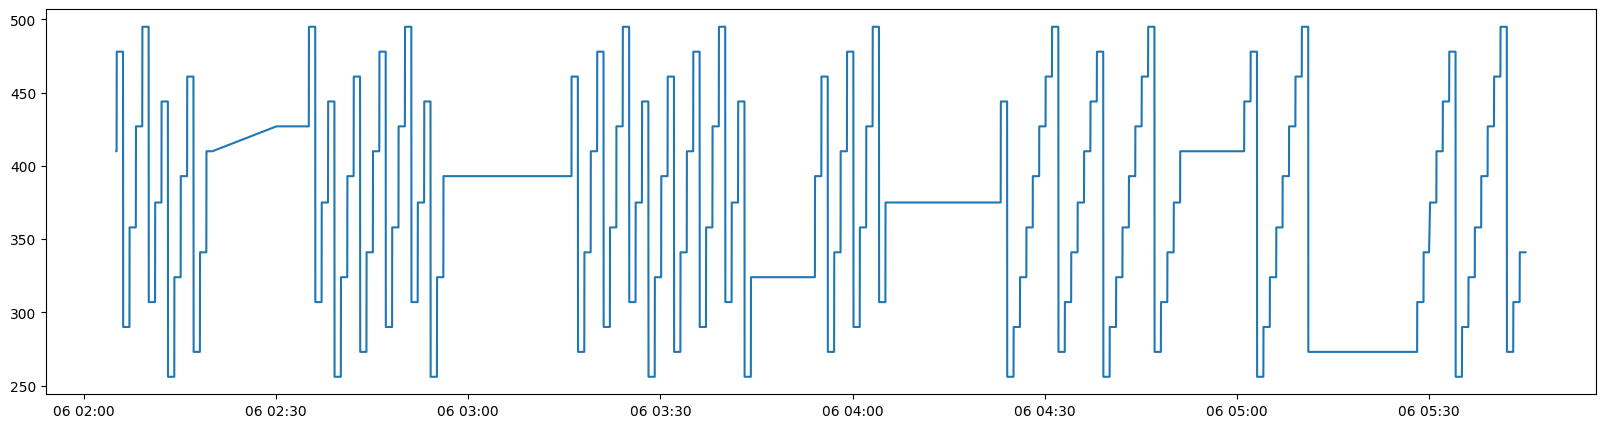

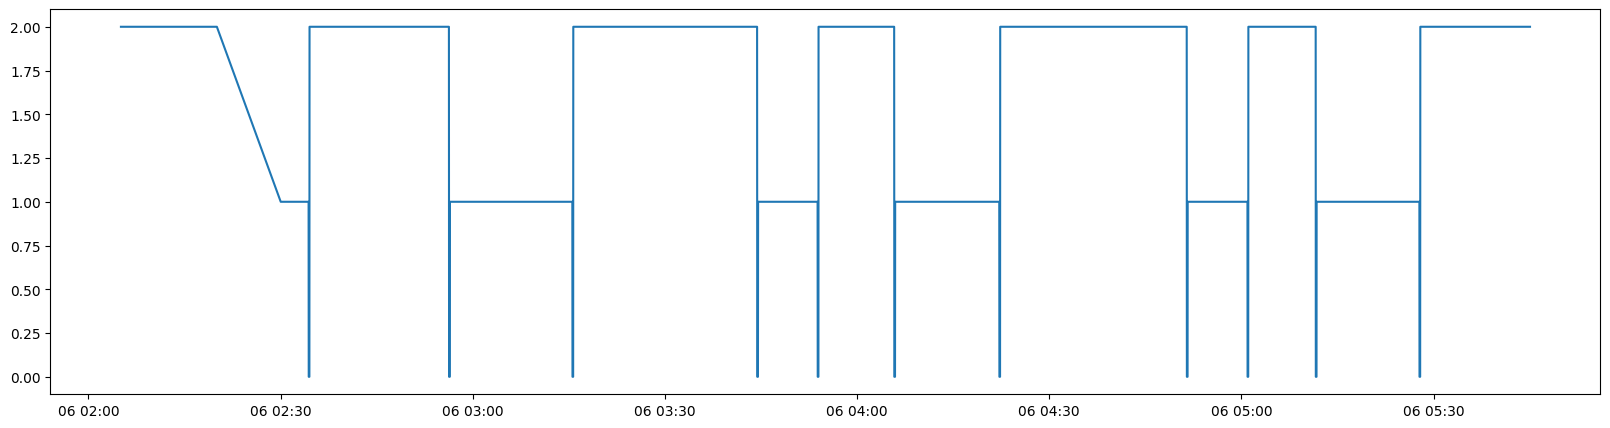

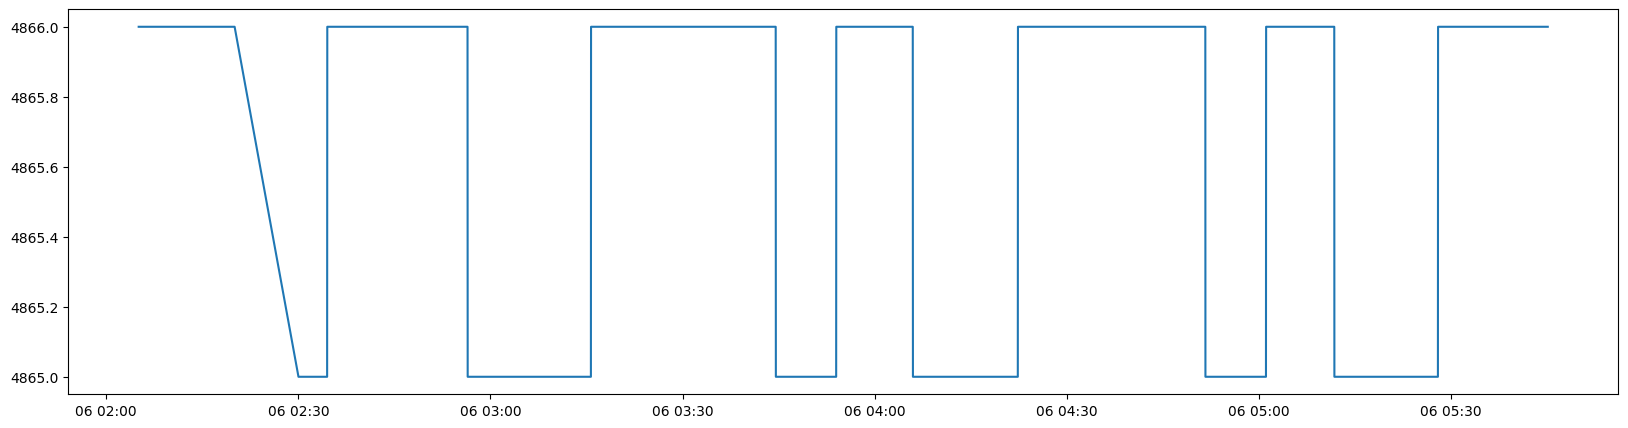

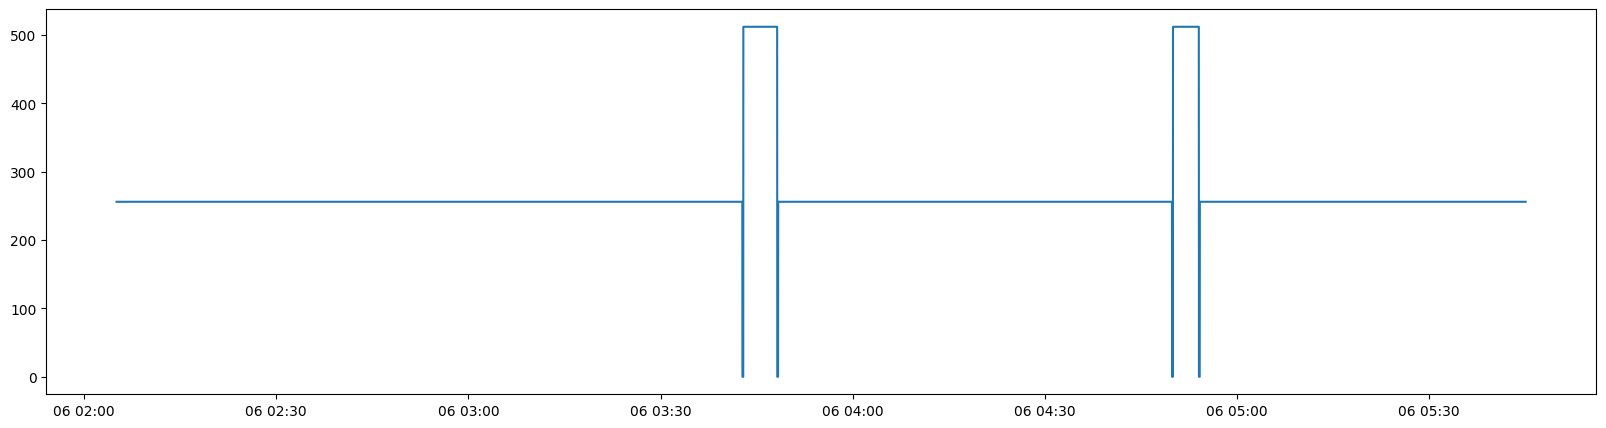

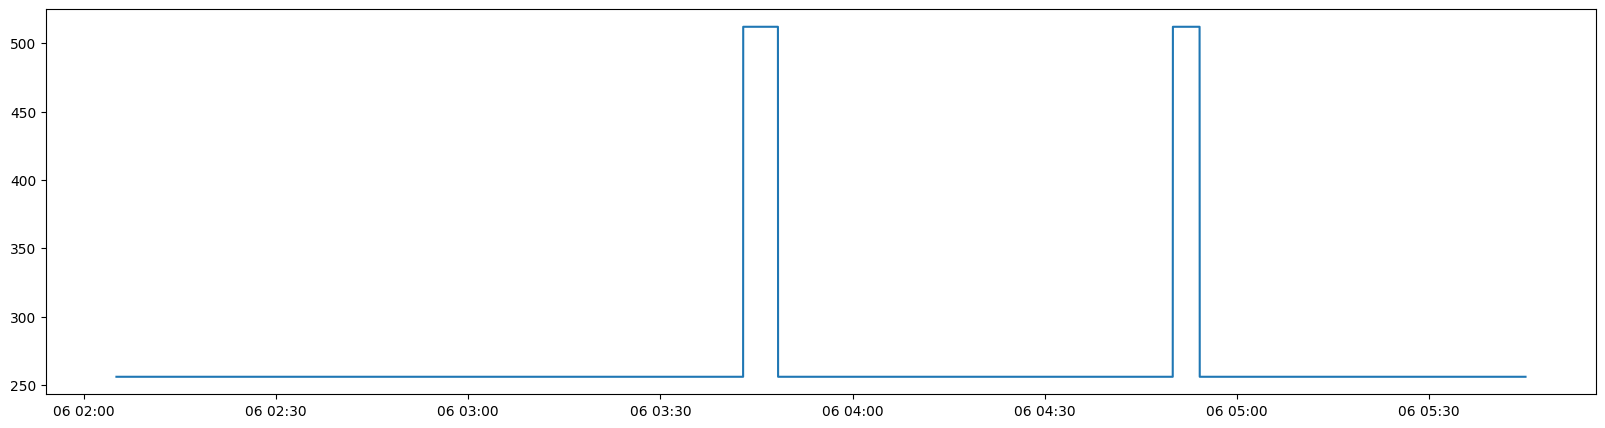

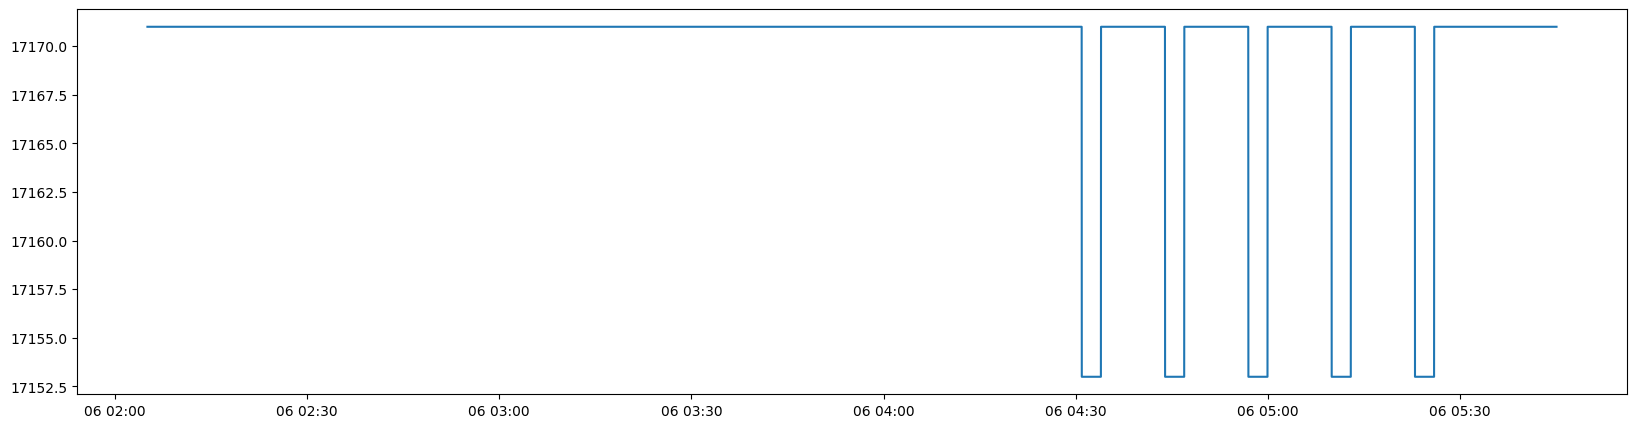

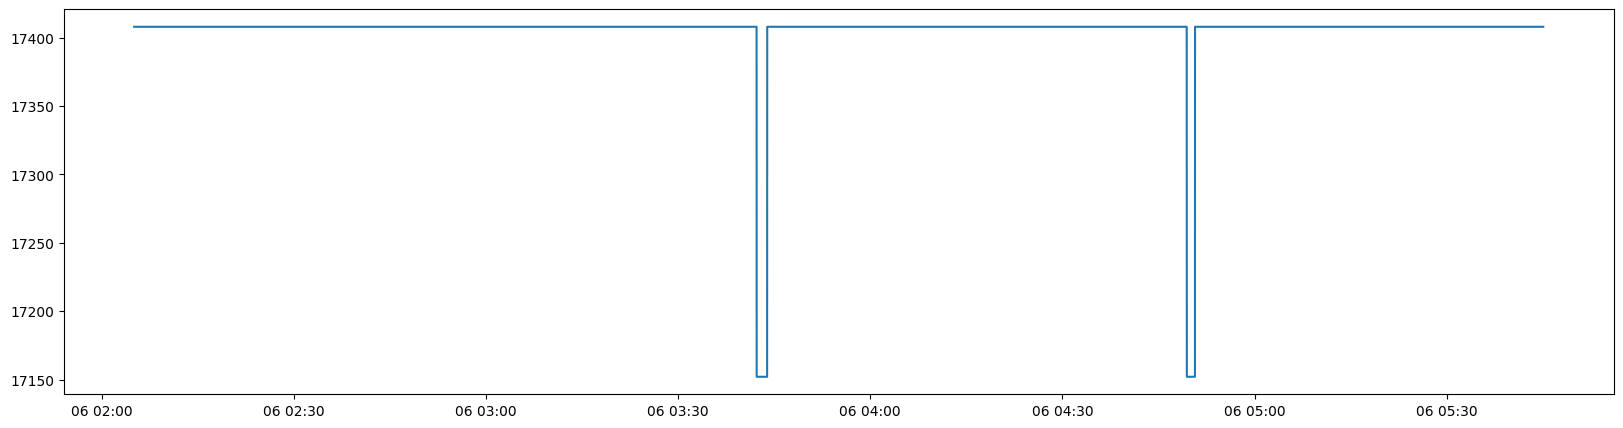

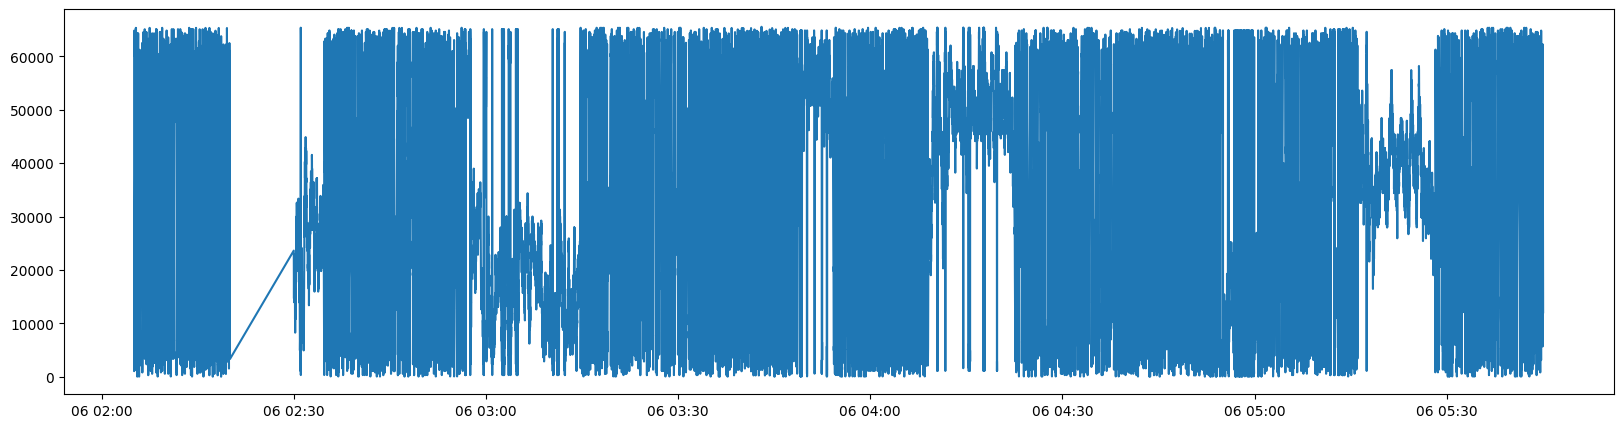

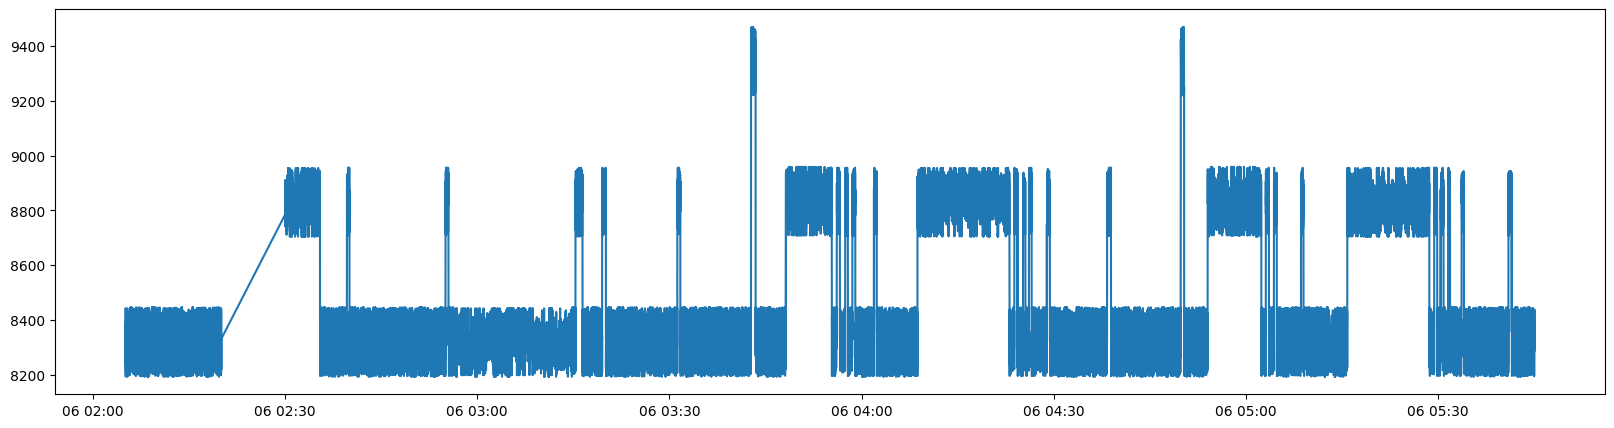

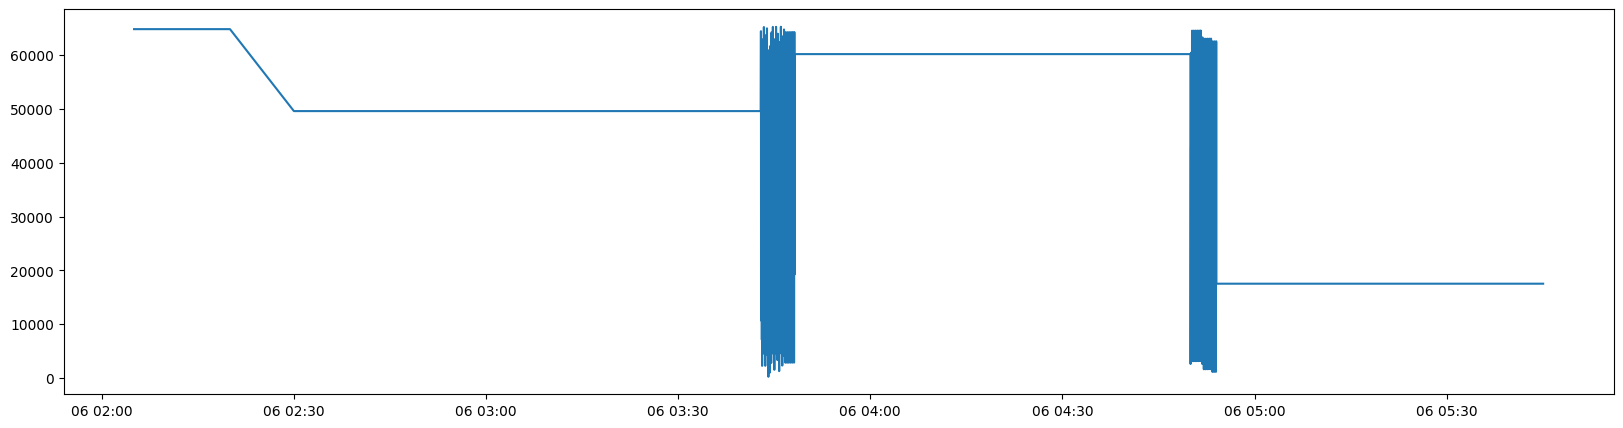

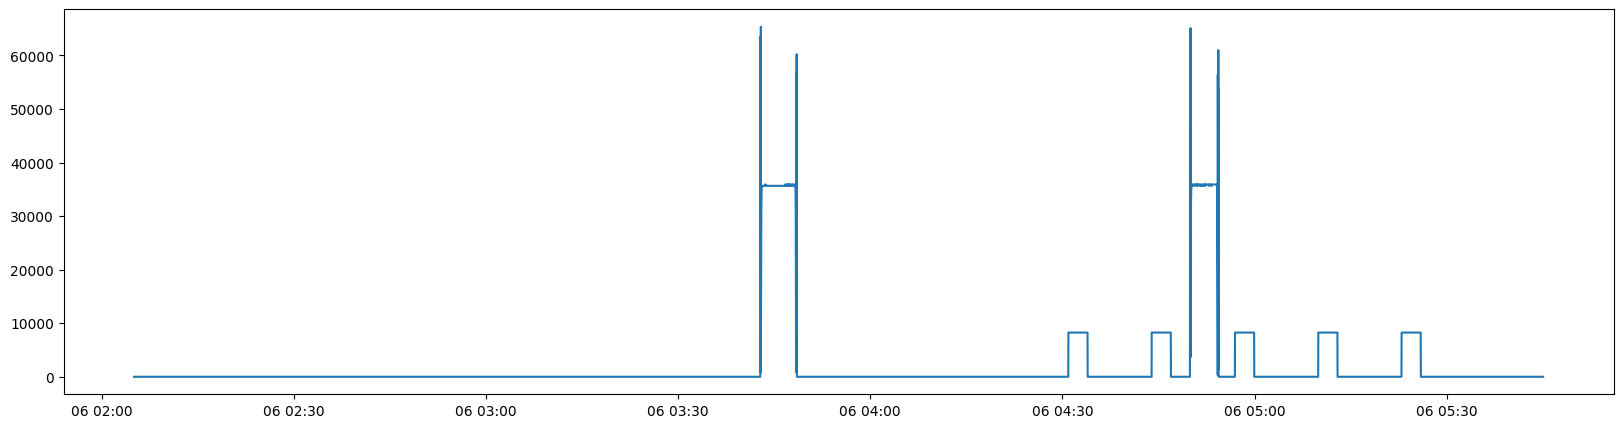

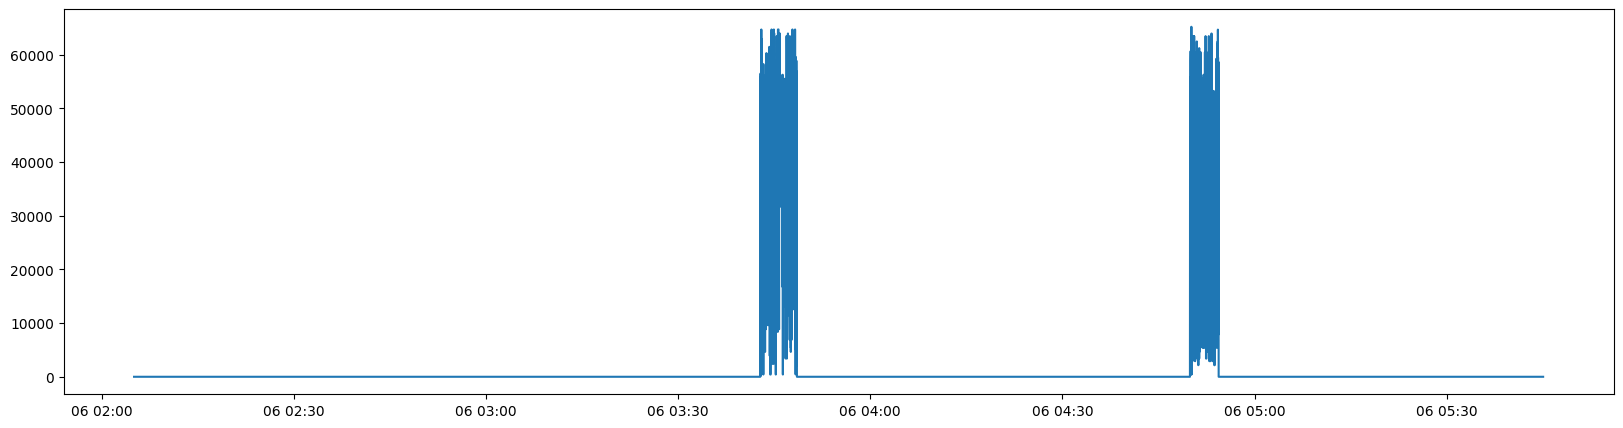

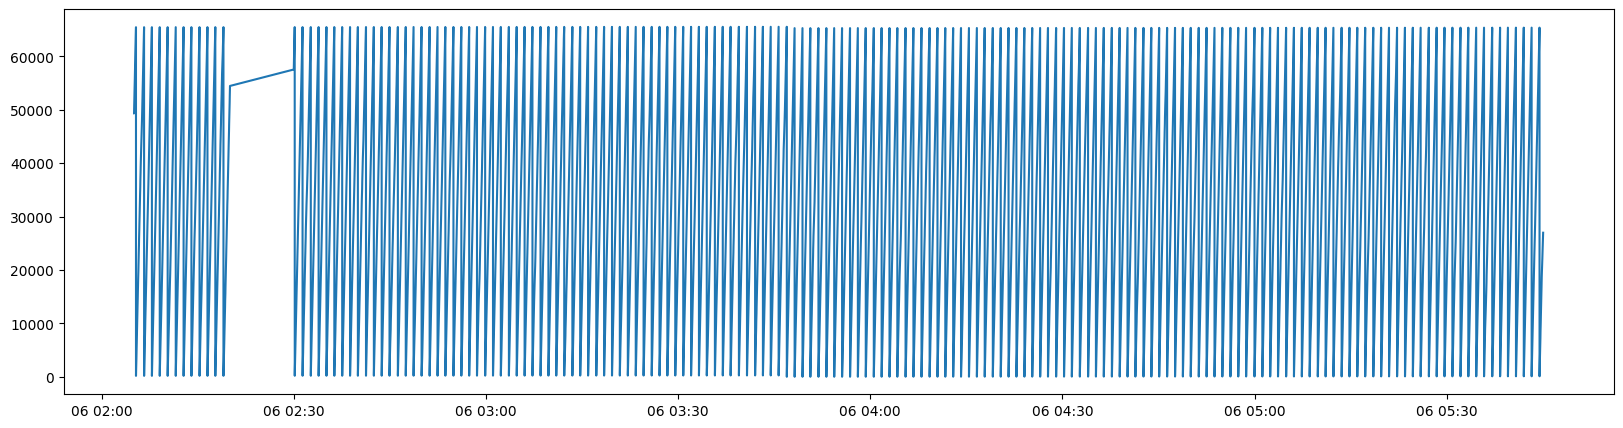

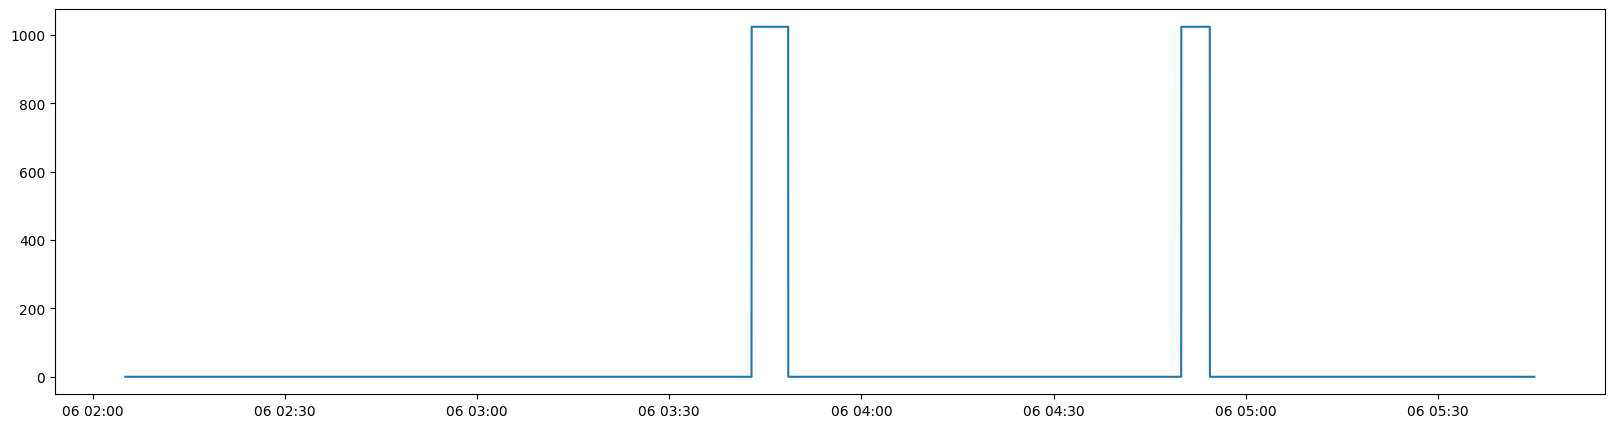

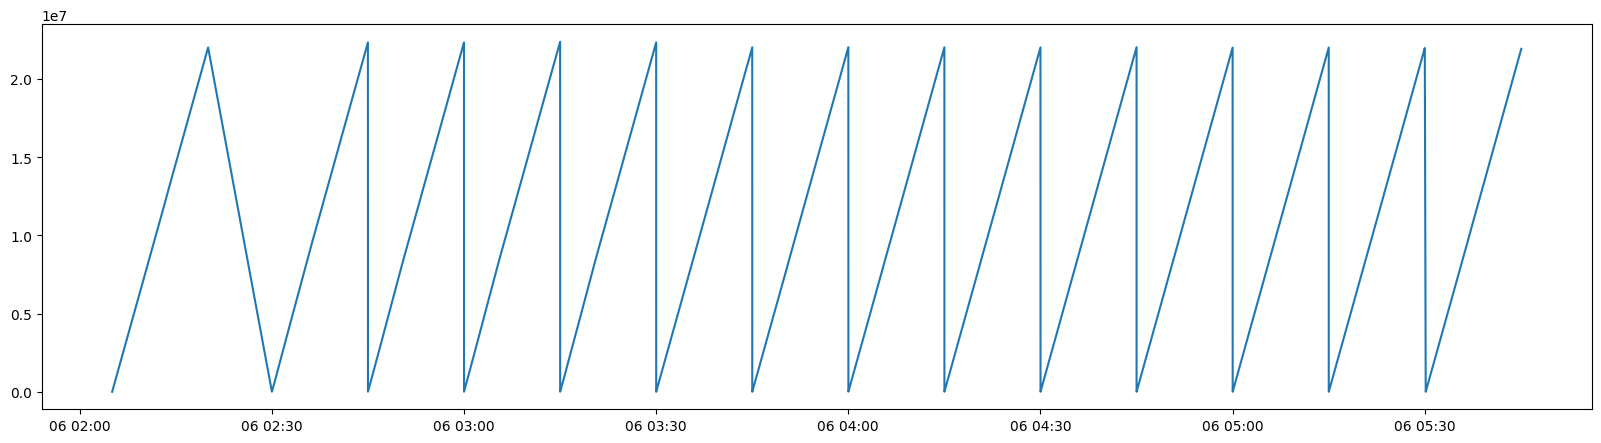

In [21]:
for col in df_bytes_converted.columns:
    plt.figure(figsize=(20,5))
    plt.plot(df_bytes_converted[col])
    plt.show()

In [22]:
df_train = df_bytes_converted.loc[:'2019-12-06 04:30:00'].copy().fillna(method='ffill')
df_train_id = df_train.pop('id')
df_train.head(3)

7      8  19   21   22   30     32   33  \
timestamp                                                                    
2019-12-06 02:05:04.415631056  59202  48187   1  257  768  512  39273  410   
2019-12-06 02:05:04.415632010  59202  48187   1  257  768  512  39273  410   
2019-12-06 02:05:04.532814026  59202  48187   1  257  768  512  39273  410   

                               37    38  ...   40     41     51     52    53  \
timestamp                                ...                                   
2019-12-06 02:05:04.415631056   2  4866  ...  256  17171  17408  61476  8362   
2019-12-06 02:05:04.415632010   2  4866  ...  256  17171  17408  61476  8362   
2019-12-06 02:05:04.532814026   2  4866  ...  256  17171  17408  60196  8355   

                                  56  66  67     80  67_3  
timestamp                                                  
2019-12-06 02:05:04.415631056  64828   0   0  49325     0  
2019-12-06 02:05:04.415632010  64828   0   0  49325     0  
2019-12-06 02:05:04.532814026  64828   0   0  49581     0  

[3 rows x 21 columns]

In [23]:
anomaly_idxs = [['2019-12-06 04:30:55', '2019-12-06 04:33:55'],
                ['2019-12-06 04:43:55', '2019-12-06 04:46:55'],
                ['2019-12-06 04:56:55', '2019-12-06 04:59:55'], 
                ['2019-12-06 05:09:55', '2019-12-06 05:12:55'], 
                ['2019-12-06 05:22:55', '2019-12-06 05:25:55']]

In [24]:
df_test = df_bytes_converted.loc['2019-12-06 04:30:00':].copy().fillna(method='ffill').fillna(method='bfill')
df_test_id = df_test.pop('id')

df_test['anomaly'] = 0

for idx in anomaly_idxs:
    df_test['anomaly'].loc[idx[0]:idx[1]] = 1

df_test.head(3)

7      8  19   21   22   30     32   33  \
timestamp                                                                    
2019-12-06 04:30:00.014081001  59970  13107   1  257  512  512  43648  427   
2019-12-06 04:30:00.014082909  59970  13107   1  257  512  512  43648  427   
2019-12-06 04:30:00.518059968  59970  13107   1  257  512  512  43648  427   

                               37    38  ...     41     51     52    53  \
timestamp                                ...                              
2019-12-06 04:30:00.014081001   2  4866  ...  17171  17408  48707  8291   
2019-12-06 04:30:00.014082909   2  4866  ...  17171  17408  48707  8291   
2019-12-06 04:30:00.518059968   2  4866  ...  17171  17408  39747  8247   

                                  56  66  67     80  67_3  anomaly  
timestamp                                                           
2019-12-06 04:30:00.014081001  60188   0   0  51746     0        0  
2019-12-06 04:30:00.014082909  60188   0   0  51746     0        0  
2019-12-06 04:30:00.518059968  60188   0   0  52002     0        0  

[3 rows x 22 columns]

In [25]:
summary = {}

## Подготовка train/test

In [26]:
x_train, x_test, y_test = get_traintest(df_train.copy(), df_test.copy())

Scaling... (Standard)
Количество аномалий: 20.1%

Counter({0: 23968, 1: 6034})
Размеры выборок:
            x_train: (54406, 21)
            x_test: (30002, 21)
            y_test: (30002,)


/opt/python37/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/opt/python37/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/opt/python37/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


## OC SVM

In [30]:
description='SWAT_Dec19_arpe_svm_default'

model = OCSVM()
predictor = Predictor(model, [x_train, x_test, y_test], descr=description, resave_model=False)

2022-09-09 11:31:59.721356: can't find saved model, fit model...


In [31]:
y_pred = predictor.get_anomalies()
summary[description] = predictor.get_score()

SWAT_Dec19_arpe_svm_default
f1_score: 0.46
accuracy_score: 0.53
precision_score: 0.30
recall_score: 1.00


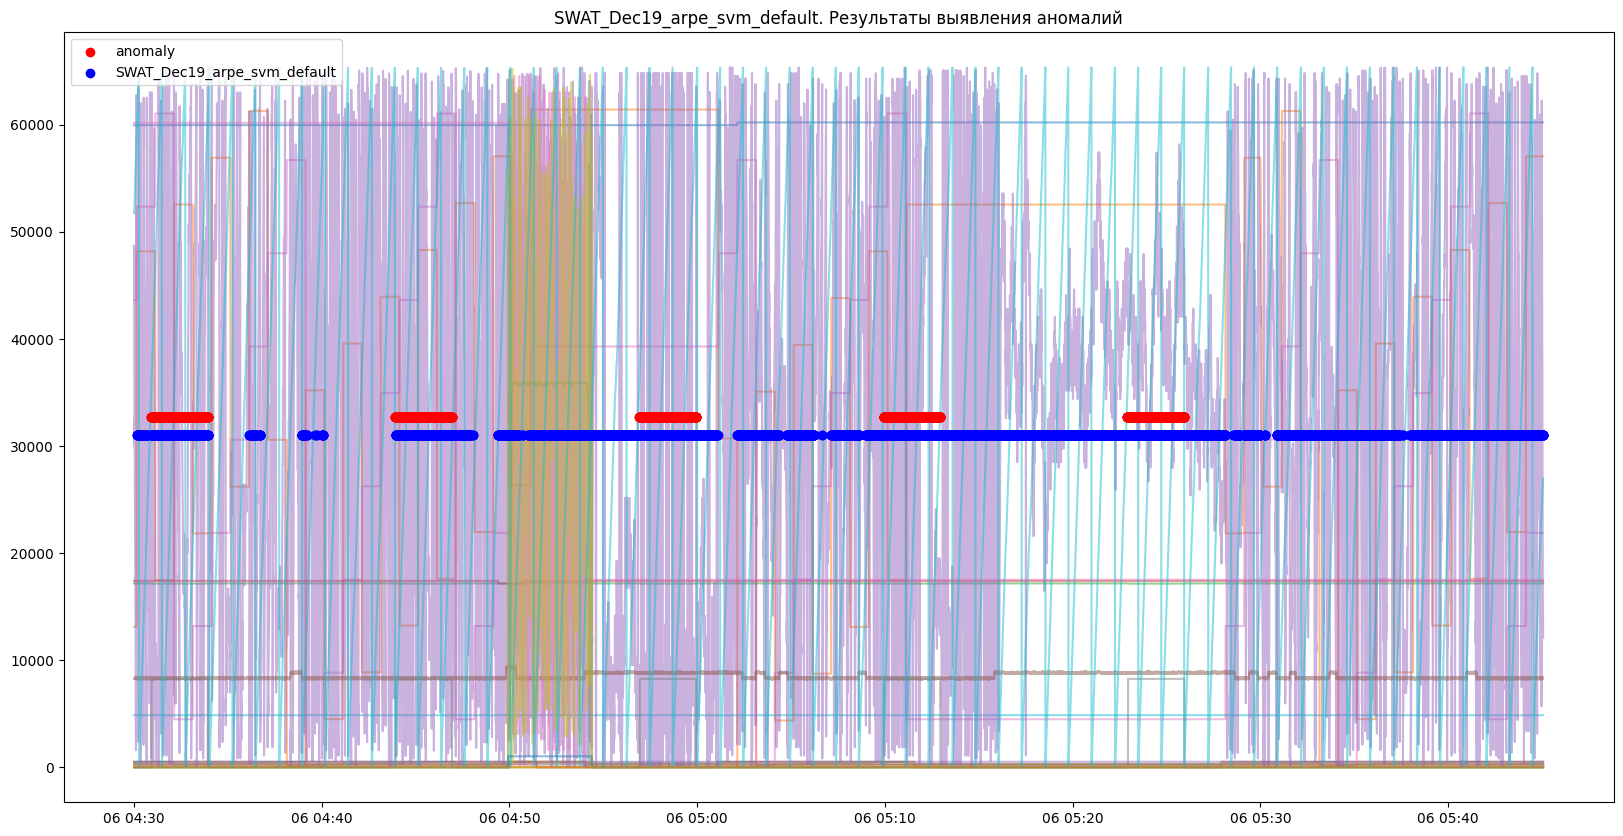

In [32]:
plot_result(df_test, y_test, y_pred, descr=description)

Scaling... (MinMax)
Количество аномалий: 20.1%

Counter({0: 23968, 1: 6034})
Размеры выборок:
            x_train: (54406, 21)
            x_test: (30002, 21)
            y_test: (30002,)
2022-09-09 11:32:03.217254: can't find saved model, fit model...


/opt/python37/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/opt/python37/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/opt/python37/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


SWAT_Dec19_arpe_svm_minmax
f1_score: 0.42
accuracy_score: 0.44
precision_score: 0.26
recall_score: 1.00


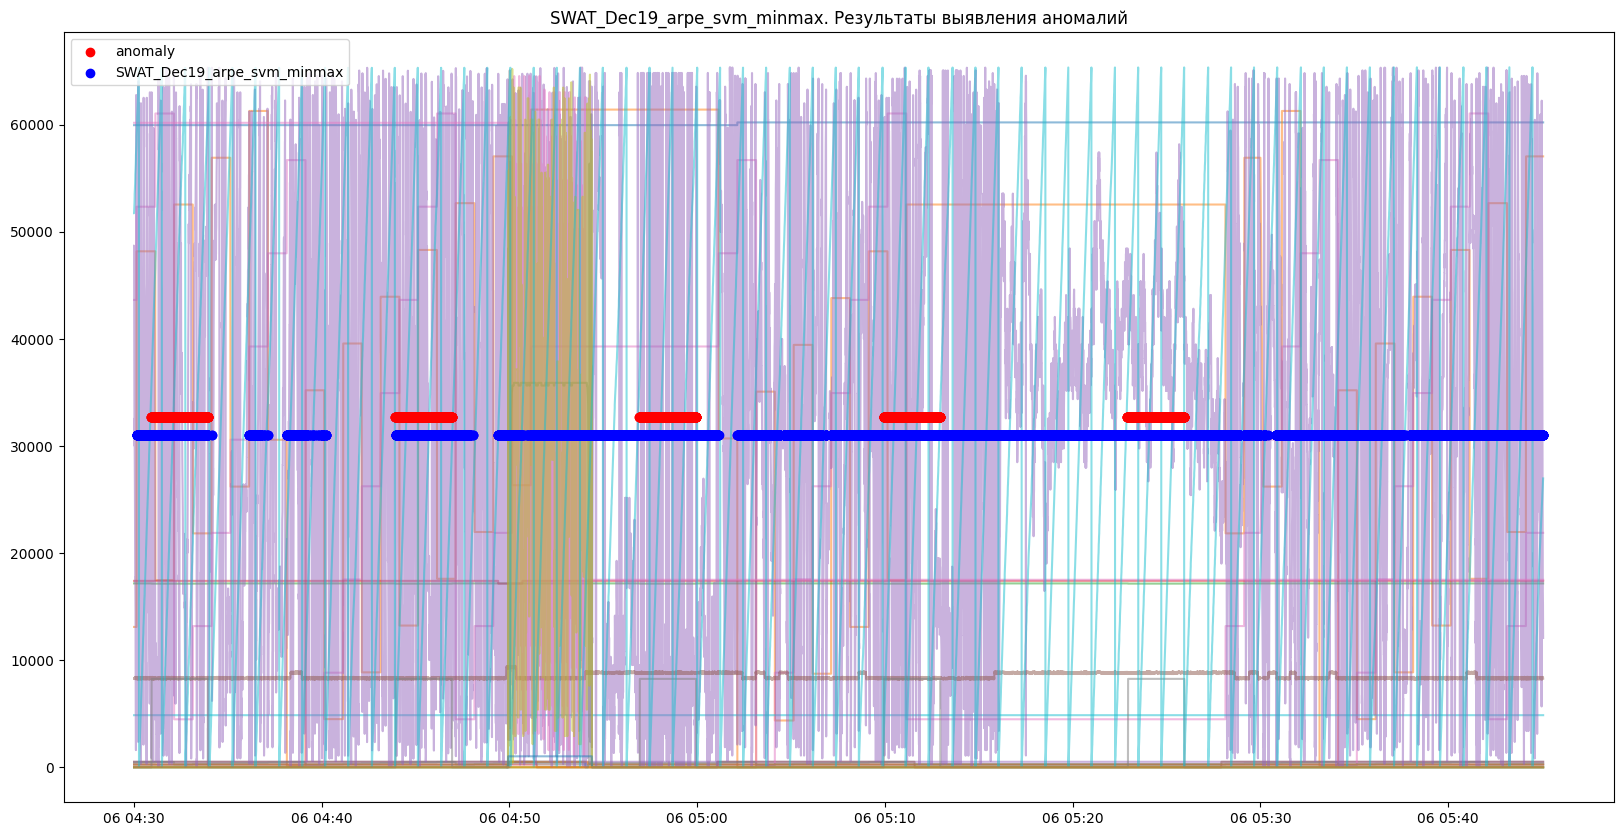

In [33]:
description='SWAT_Dec19_arpe_svm_minmax'

x_train, x_test, y_test = get_traintest(df_train.copy(), 
                                        df_test.copy(),
                                        scaler='MinMax')

predictor = Predictor(model, [x_train, x_test, y_test], descr=description)

y_pred = predictor.get_anomalies()
summary[description] = predictor.get_score()
plot_result(df_test, y_test, y_pred, descr=description)

## LOF

In [44]:
anomaly_idx = [i for i in range(len(y_test)) if y_test[i] == 1]

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [45]:
x_train, x_test, y_test = get_traintest(df_train.copy(), 
                                        df_test.copy())

Scaling... (Standard)
Количество аномалий: 20.1%

Counter({0: 23968, 1: 6034})
Размеры выборок:
            x_train: (54406, 21)
            x_test: (30002, 21)
            y_test: (30002,)


/opt/python37/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/opt/python37/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/opt/python37/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


/opt/python37/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


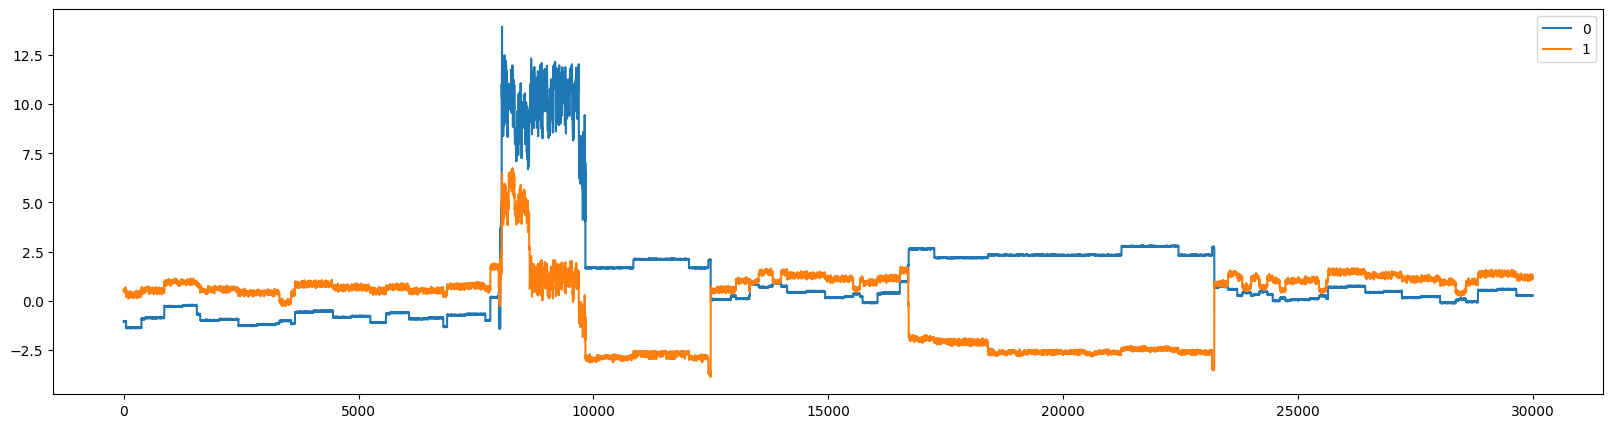

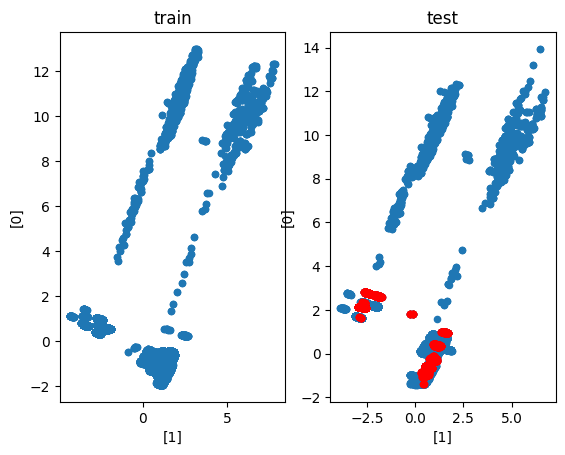

In [46]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principalComponents = pca.fit(x_train)

x_train_2d = pd.DataFrame(data = principalComponents.transform(x_train))
x_test_2d = pd.DataFrame(data = principalComponents.transform(x_test))
x_test_2d.plot(figsize=(20,5))

fig, (ax, ax_test) = plt.subplots(1, 2)
x_train_2d.plot.scatter(x=[1], y=[0], title='train', ax=ax)
x_test_2d.plot.scatter(x=[1], y=[0], title='test', ax=ax_test)
x_test_2d.iloc[anomaly_idx].plot.scatter(x=[1], y=[0], title='test', c='r', ax=ax_test)
plt.show()

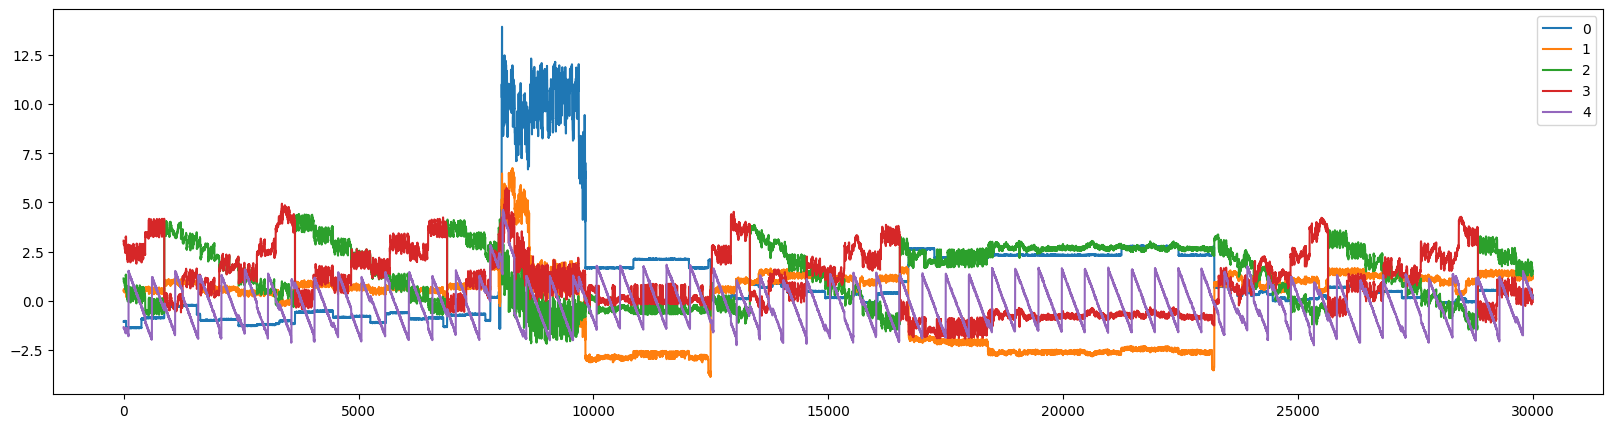

In [48]:
N_COMPONENTS = 5

pca = PCA(n_components=N_COMPONENTS)
principalComponents = pca.fit(x_train)

x_train_pca = pd.DataFrame(data = principalComponents.transform(x_train))
x_test_pca = pd.DataFrame(data = principalComponents.transform(x_test))
x_test_pca.plot(figsize=(20,5))
plt.show()

In [49]:
model = LOF()

2022-09-09 11:33:43.428713: refit model...
Train prediction score statistics
            min: -3.644679266248697
            mean: -1.0515679777666165
            max: -0.8316948437406888


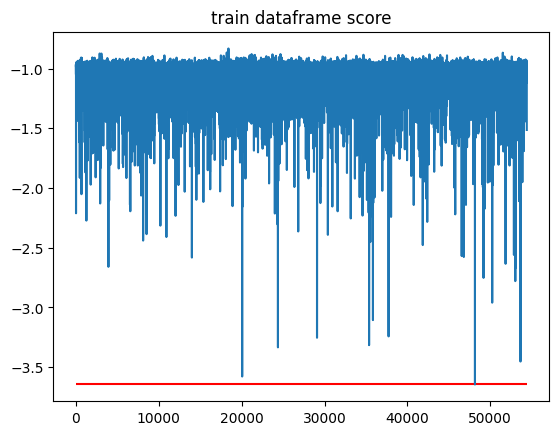

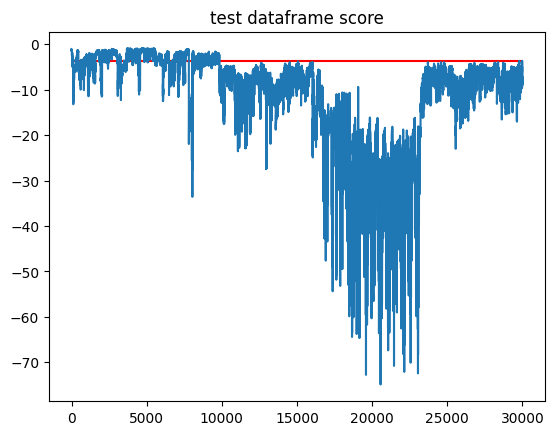

SWAT_Dec19_arpe_lof_n_5
f1_score: 0.33
accuracy_score: 0.33
precision_score: 0.21
recall_score: 0.81


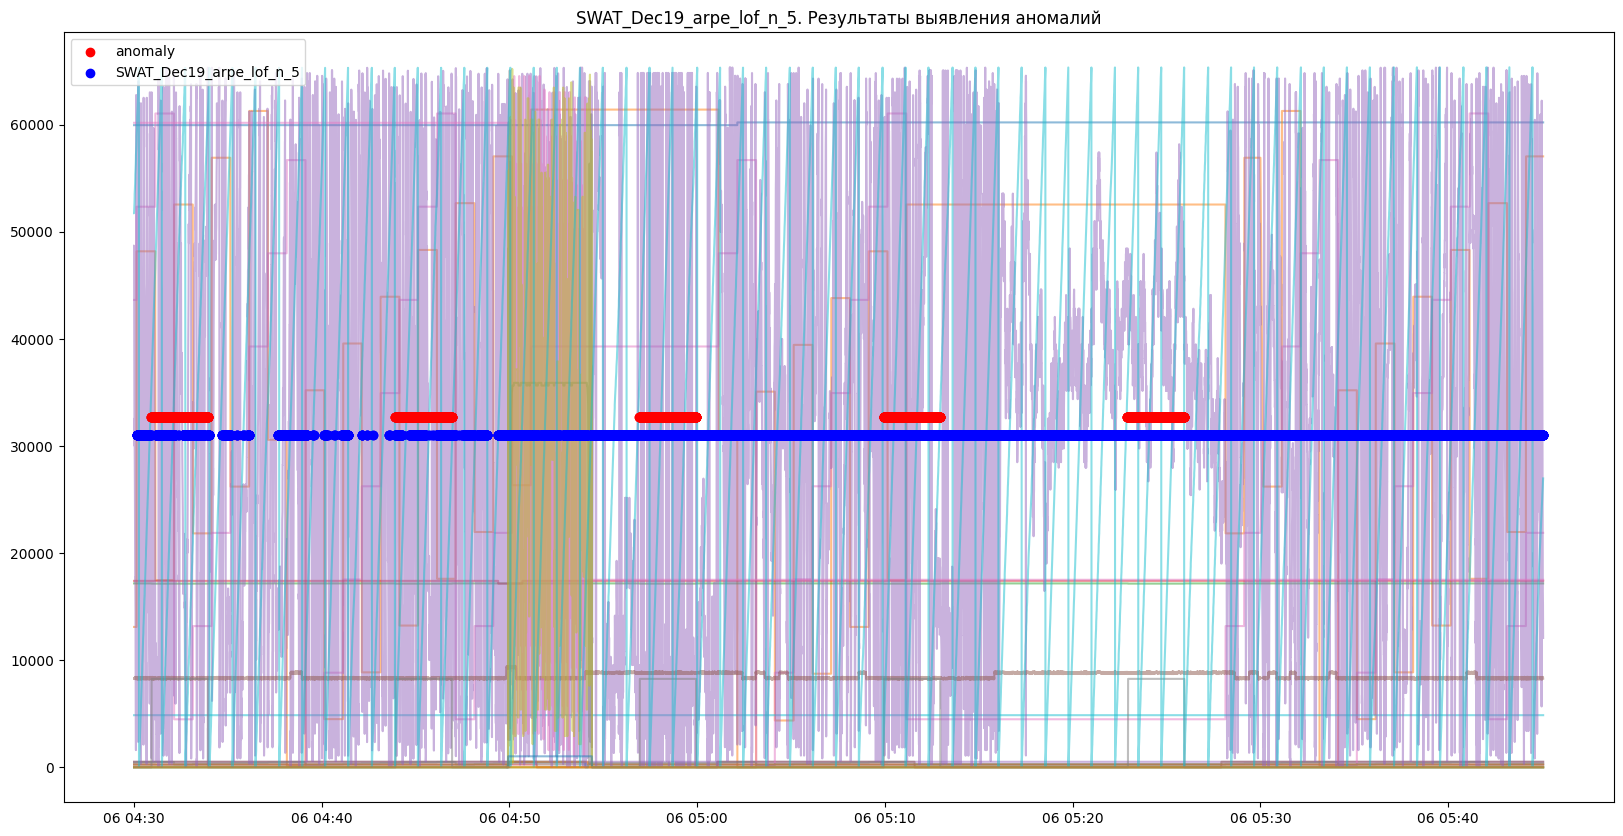

In [50]:
description = f'SWAT_Dec19_arpe_lof_n_{N_COMPONENTS}'
predictor = Predictor(model, [x_train_pca, x_test_pca, y_test], descr=description, resave_model=True)

y_pred = predictor.get_anomalies()
summary[description] = predictor.get_score()
plot_result(df_test, y_test, y_pred, descr=description)

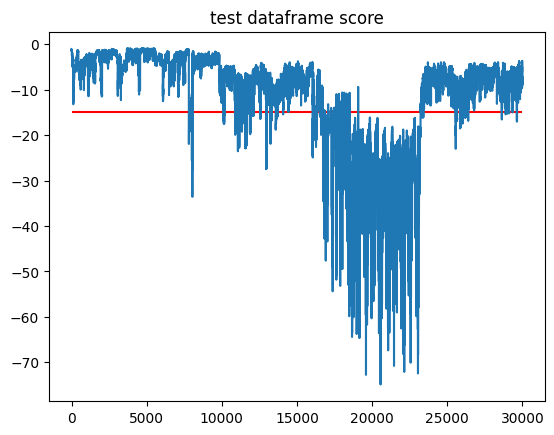

SWAT_Dec19_arpe_lof_n_5
f1_score: 0.32
accuracy_score: 0.71
precision_score: 0.30
recall_score: 0.35


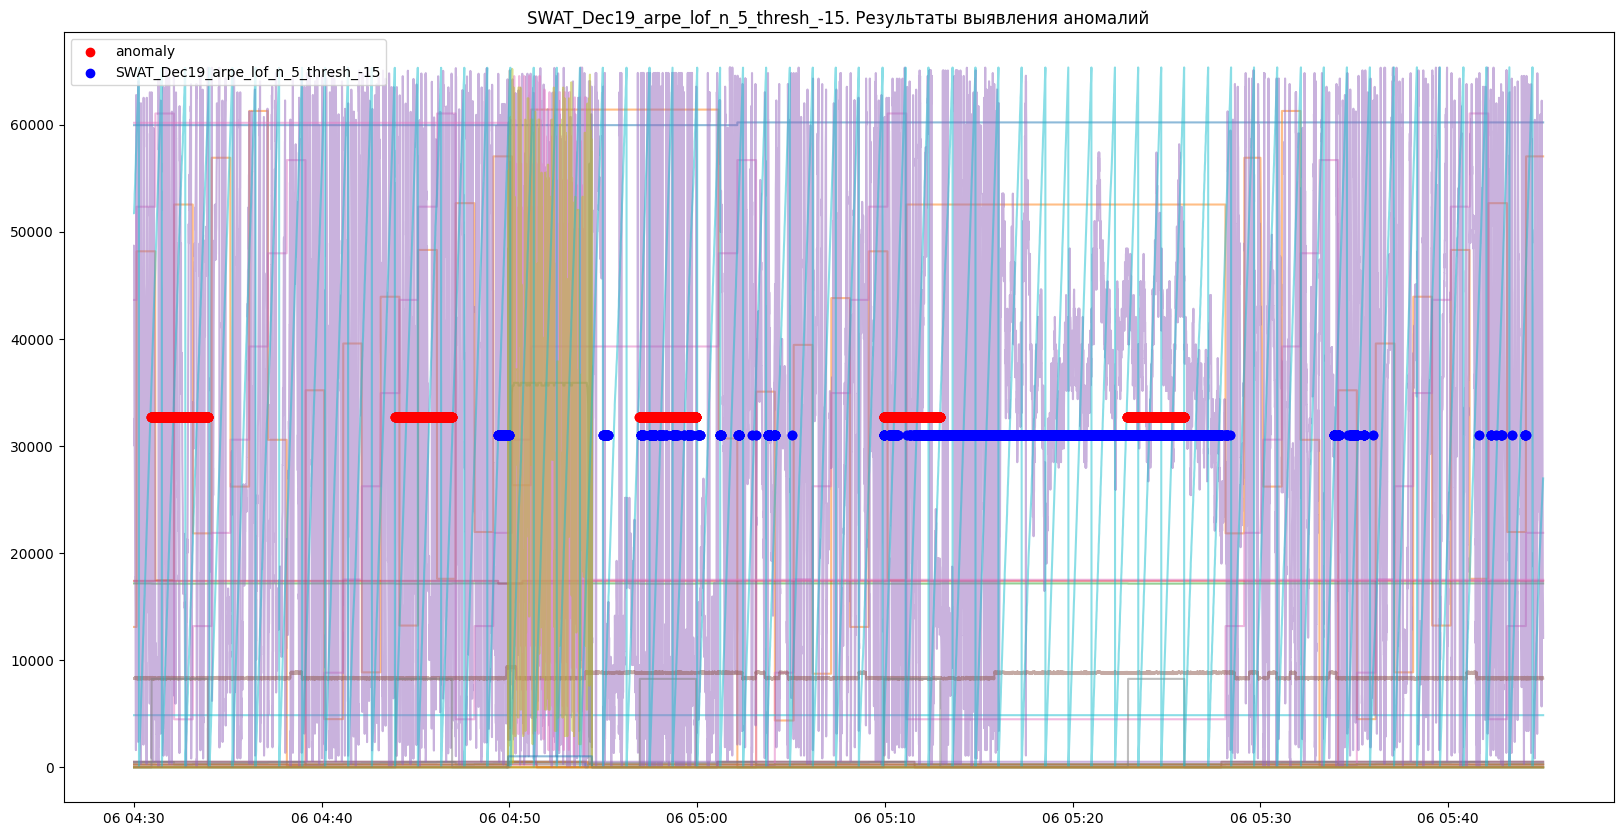

In [51]:
threshold=-15

y_pred = predictor.get_anomalies(threshold=threshold)
summary[f'{description}_thresh_{threshold}'] = predictor.get_score()
plot_result(df_test, y_test, y_pred, descr=f'{description}_thresh_{threshold}')

## iForest

Scaling... (Standard)
Количество аномалий: 20.1%

Counter({0: 23968, 1: 6034})
Размеры выборок:
            x_train: (54406, 21)
            x_test: (30002, 21)
            y_test: (30002,)
2022-09-09 11:34:44.251745: find saved model: ./saved_models/SWAT_Dec19_arpe_iF_default, loading...


/opt/python37/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/opt/python37/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/opt/python37/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


SWAT_Dec19_arpe_iF_default
f1_score: 0.00
accuracy_score: 0.80
precision_score: 0.00
recall_score: 0.00


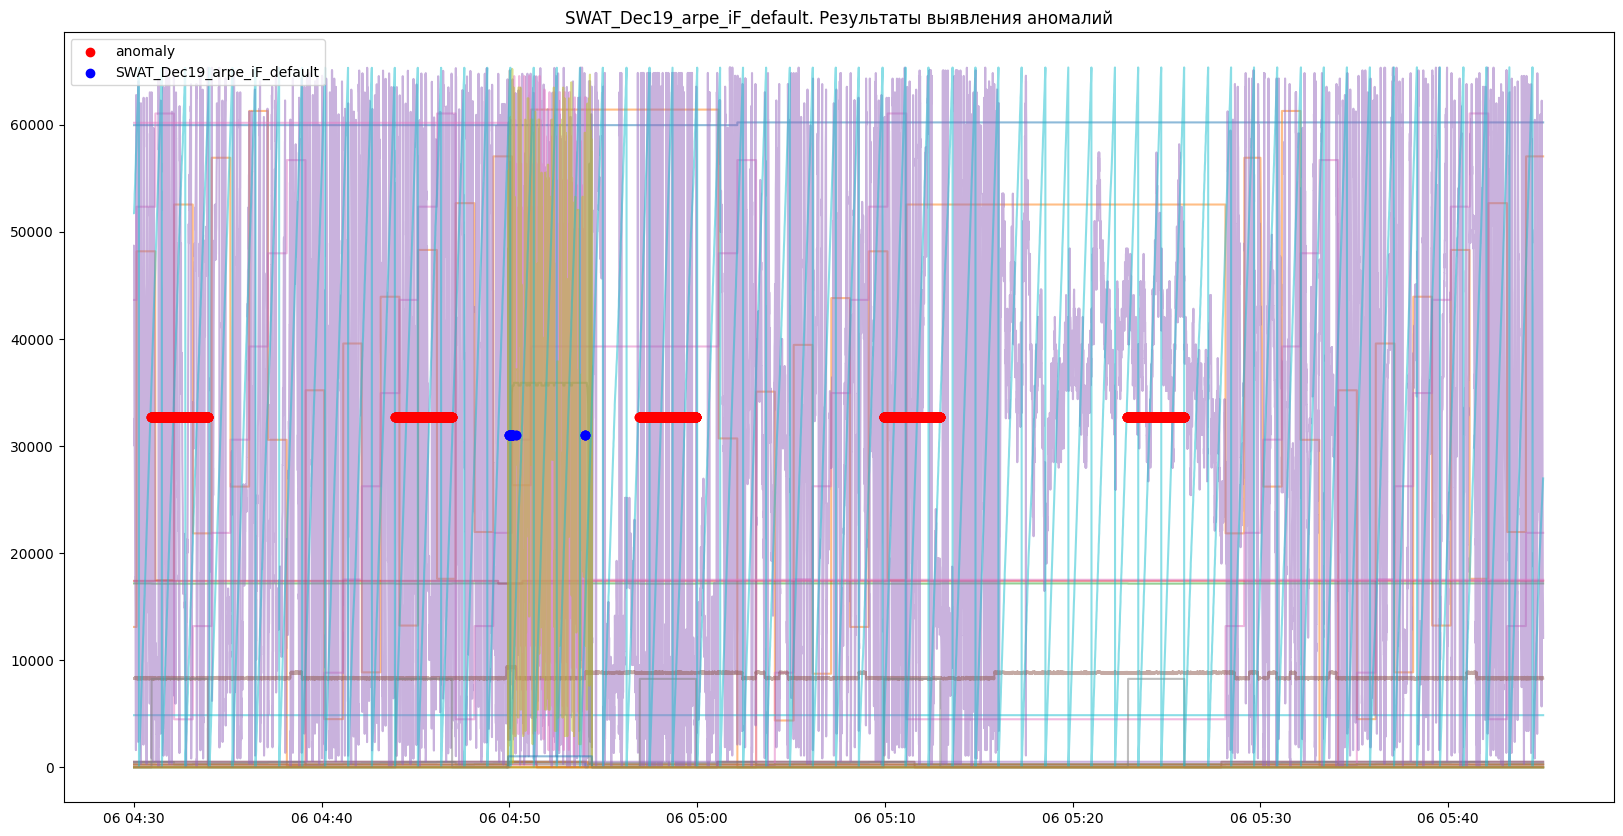

In [52]:
description = f'SWAT_Dec19_arpe_iF_default'

x_train, x_test, y_test = get_traintest(df_train.copy(), df_test.copy())

model = iForest()

predictor = Predictor(model, [x_train, x_test, y_test], descr=description, resave_model=False)
y_pred = predictor.get_anomalies()
summary[description] = predictor.get_score()
plot_result(df_test, y_test, y_pred, descr=description)

Scaling... (Standard)
Количество аномалий: 20.1%

Counter({0: 23968, 1: 6034})
Размеры выборок:
            x_train: (54406, 21)
            x_test: (30002, 21)
            y_test: (30002,)
2022-09-09 11:35:08.033443: refit model...


/opt/python37/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/opt/python37/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/opt/python37/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


SWAT_Dec19_arpe_iF_n_200_c_001
f1_score: 0.00
accuracy_score: 0.77
precision_score: 0.00
recall_score: 0.00


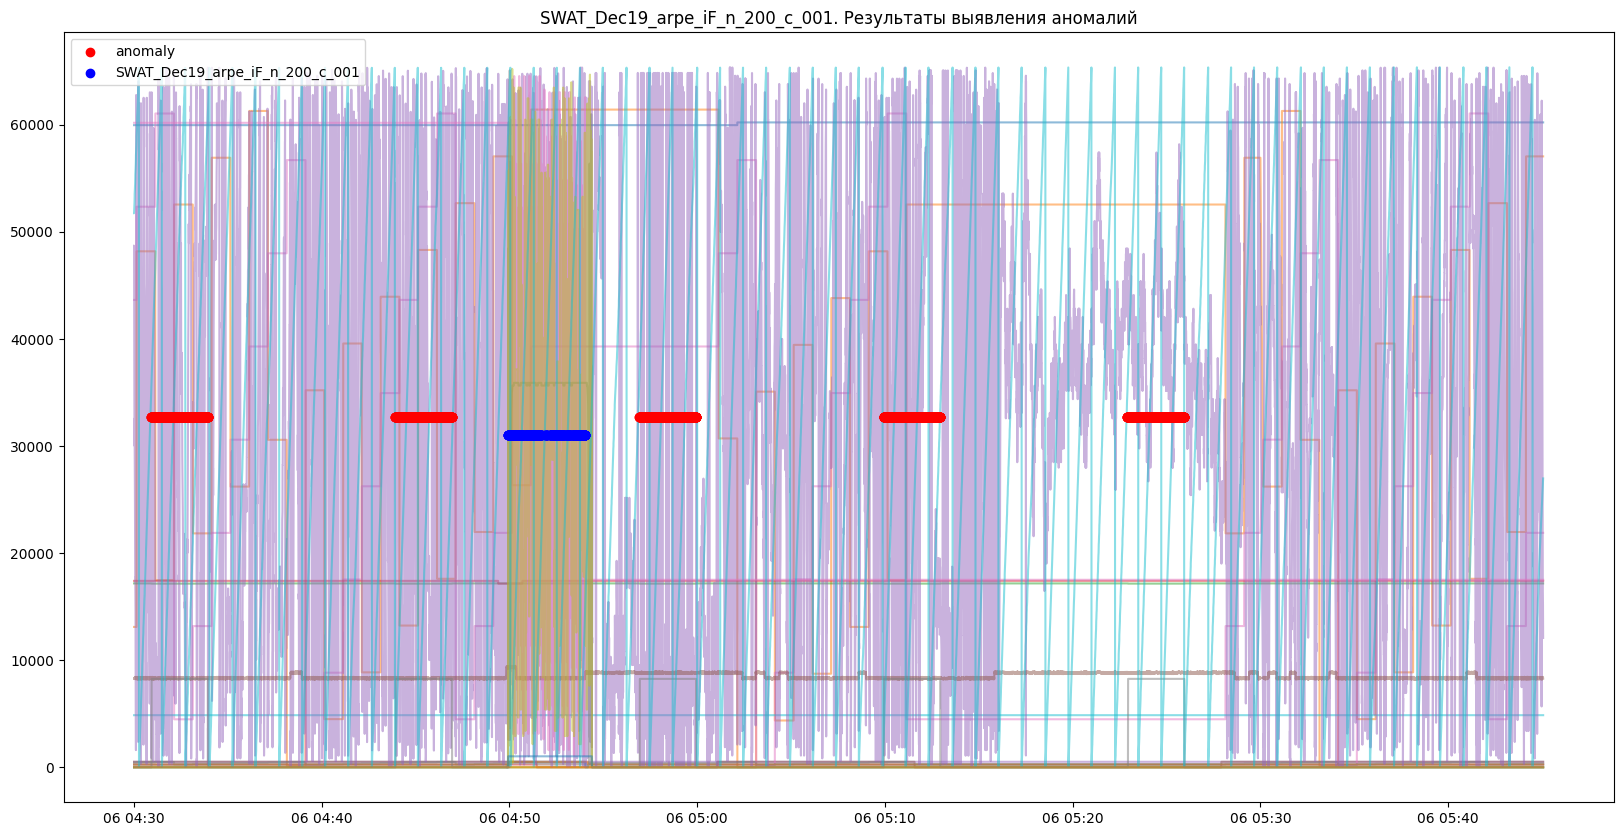

In [54]:
description = f'SWAT_Dec19_arpe_iF_n_200_c_001'

x_train, x_test, y_test = get_traintest(df_train.copy(), 
                                        df_test.copy())

model = iForest(n_estimators=200, contamination=0.01)

predictor = Predictor(model, [x_train, x_test, y_test], descr=description, resave_model=True)
y_pred = predictor.get_anomalies()
summary[description] = predictor.get_score()
plot_result(df_test, y_test, y_pred, descr=description)

## Autoencoder

Scaling... (Standard)
Количество аномалий: 20.1%

Counter({0: 23968, 1: 6034})
Resampling... (1T)
(146, 21), (76, 21), (76,),
Create sequences with window size 30...


/opt/python37/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/opt/python37/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/opt/python37/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


Размеры выборок:
            x_train: (54377, 30, 21)
            x_test: (29973, 30, 21)
            y_test: (29973, 30)
2022-09-09 11:35:37.620394: can't find saved model, fit model...
Epoch 1/10
55/55 [==============================] - 9s 165ms/step - loss: 7.7981
Epoch 2/10
55/55 [==============================] - 9s 166ms/step - loss: 4.8743
Epoch 3/10
55/55 [==============================] - 9s 173ms/step - loss: 1.7254
Epoch 4/10
55/55 [==============================] - 10s 187ms/step - loss: 0.8505
Epoch 5/10
55/55 [==============================] - 10s 175ms/step - loss: 0.6639
Epoch 6/10
55/55 [==============================] - 10s 175ms/step - loss: 0.5780
Epoch 7/10
55/55 [==============================] - 10s 173ms/step - loss: 0.4636
Epoch 8/10
55/55 [==============================] - 10s 174ms/step - loss: 0.4351
Epoch 9/10
55/55 [==============================] - 10s 174ms/step - loss: 0.9961
Epoch 10/10
55/55 [==============================] - 10s 174ms/step - loss: 0.

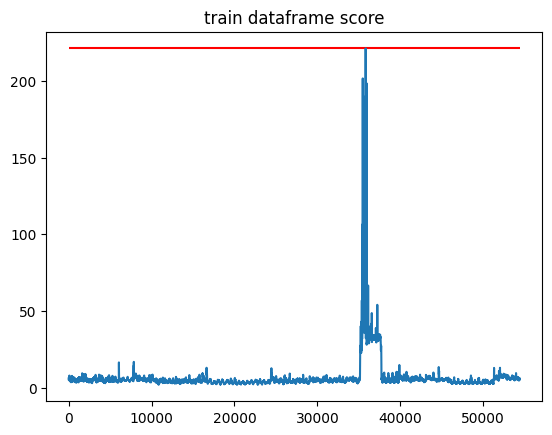

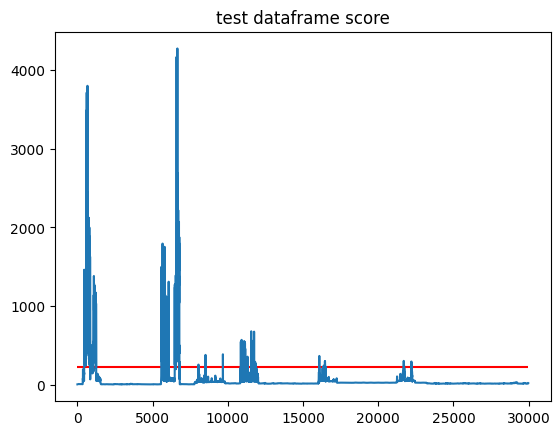

(29973,)
SWAT_Dec19_arpe_ae_lstm_window_30_resample_1T
f1_score: 0.34
accuracy_score: 0.84
precision_score: 1.00
recall_score: 0.21


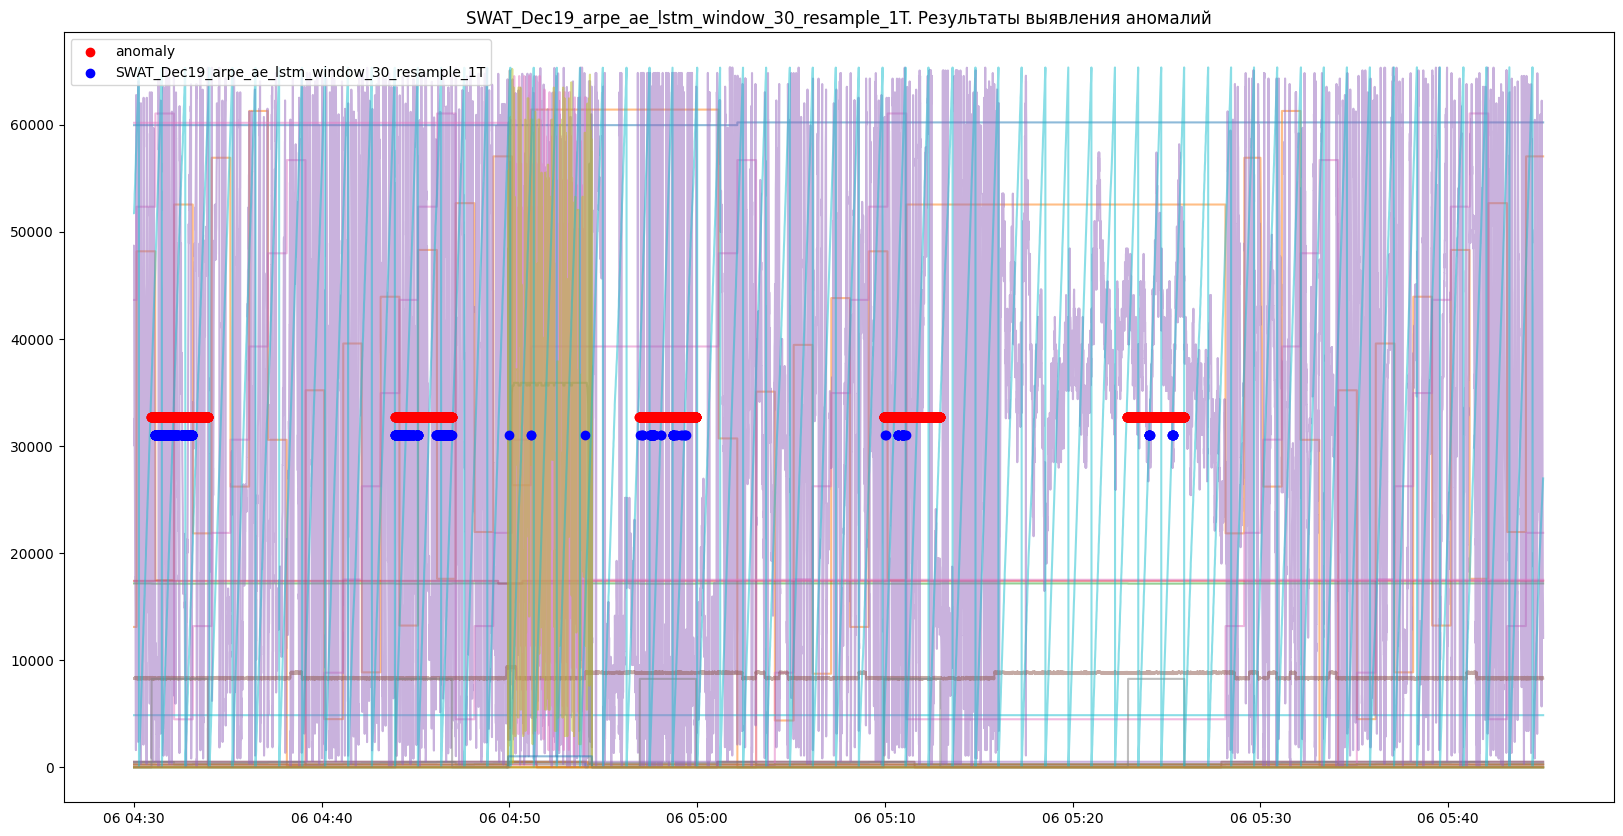

In [55]:
window_size = 30
resample_rate = '1T'

description = f'SWAT_Dec19_arpe_ae_lstm_window_{window_size}_resample_{resample_rate}'

x_train, x_test, y_test = get_traintest(df_train.copy(), 
                                        df_test.copy(), 
                                        window_size=window_size, 
                                        resample_rate=resample_rate)

model = AE_LSTM()

predictor = Predictor(model, 
                      [x_train, x_test, y_test], 
                      descr=description, 
                      window_size=window_size,
                      resave_model=False)

y_pred = predictor.get_anomalies()
summary[description] = predictor.get_score()
plot_result(df_test, y_test[:,0], y_pred, descr=description)

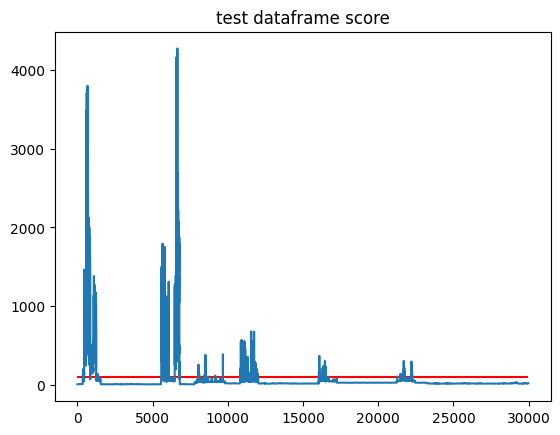

(29973,)
SWAT_Dec19_arpe_ae_lstm_window_30_resample_1T
f1_score: 0.50
accuracy_score: 0.86
precision_score: 0.99
recall_score: 0.33


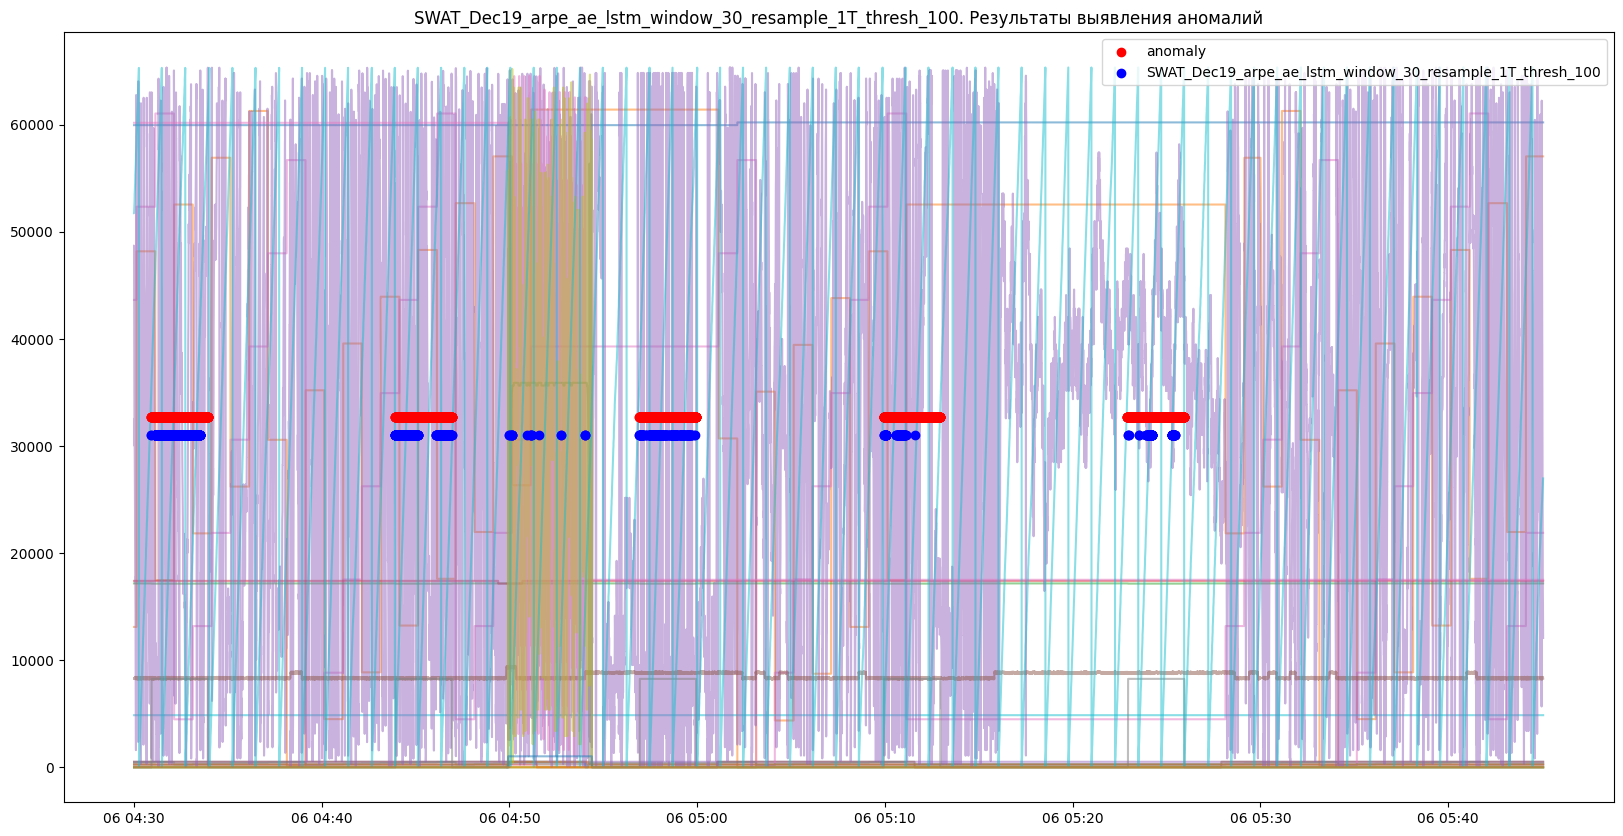

In [58]:
threshold=100

y_pred = predictor.get_anomalies(threshold=threshold)
summary[f'{description}_thresh_{threshold}'] = predictor.get_score()
plot_result(df_test, y_test[:,0], y_pred, descr=f'{description}_thresh_{threshold}')

## SOM

In [59]:
x_train, x_test, y_test = get_traintest(df_train.copy(), 
                                        df_test.copy())

Scaling... (Standard)
Количество аномалий: 20.1%

Counter({0: 23968, 1: 6034})
Размеры выборок:
            x_train: (54406, 21)
            x_test: (30002, 21)
            y_test: (30002,)


/opt/python37/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/opt/python37/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/opt/python37/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


2022-09-09 11:39:19.257758: can't find saved model, fit model...
50000


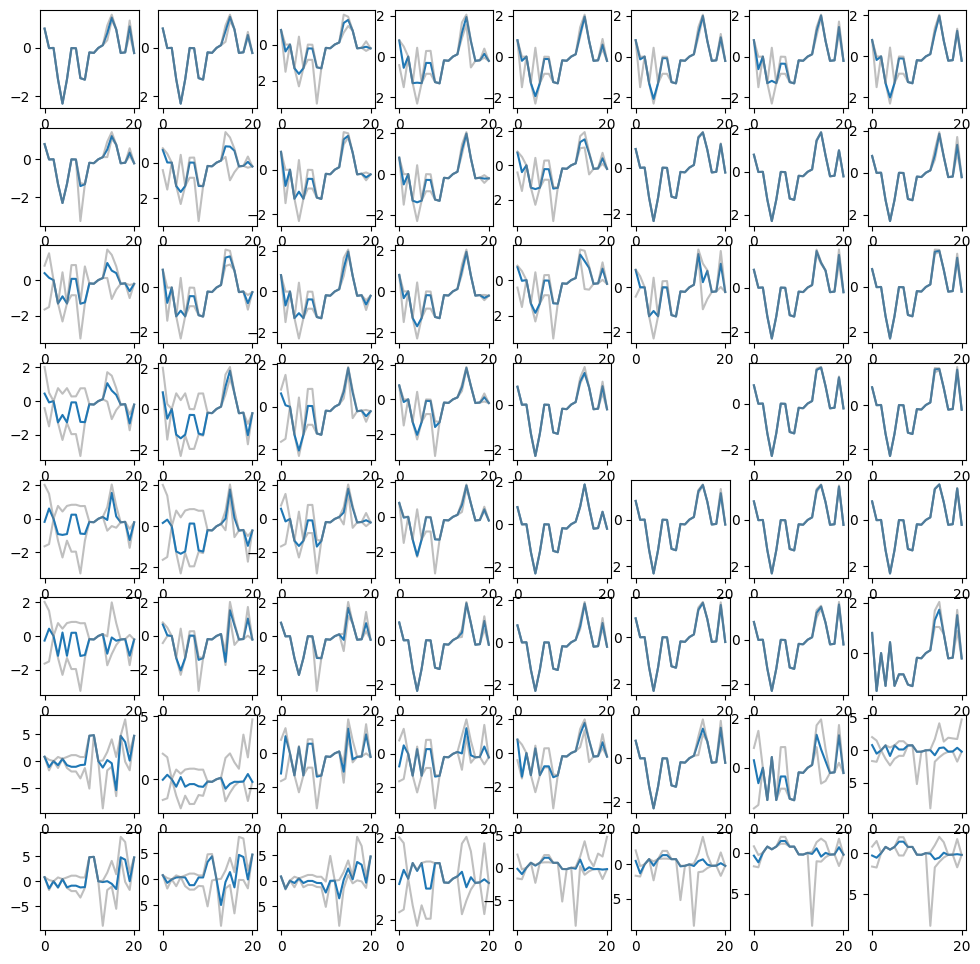

IntProgress(value=0, description='Computing', max=30002, style=ProgressStyle(bar_color='#61dc8a'))

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceed

IntProgress(value=0, description='Computing', max=54406, style=ProgressStyle(bar_color='#61dc8a'))

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceed

Train prediction score statistics
            min: 0.33640976700728725
            mean: 36.36343999462386
            max: 118.40410041512665


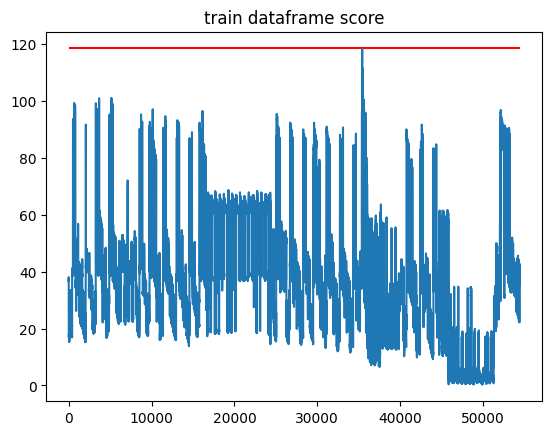

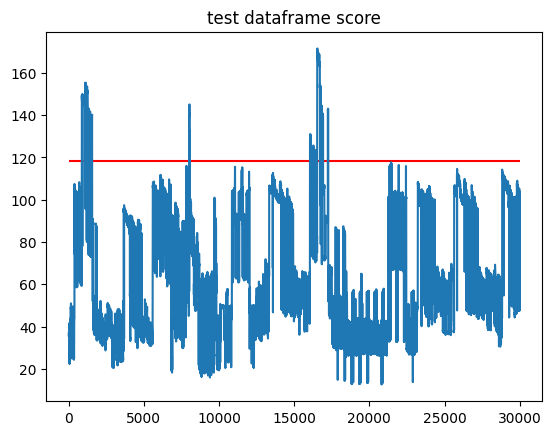

(30002,)
SWAT_Dec19_arpe_som_default
f1_score: 0.28
accuracy_score: 0.83
precision_score: 0.98
recall_score: 0.17


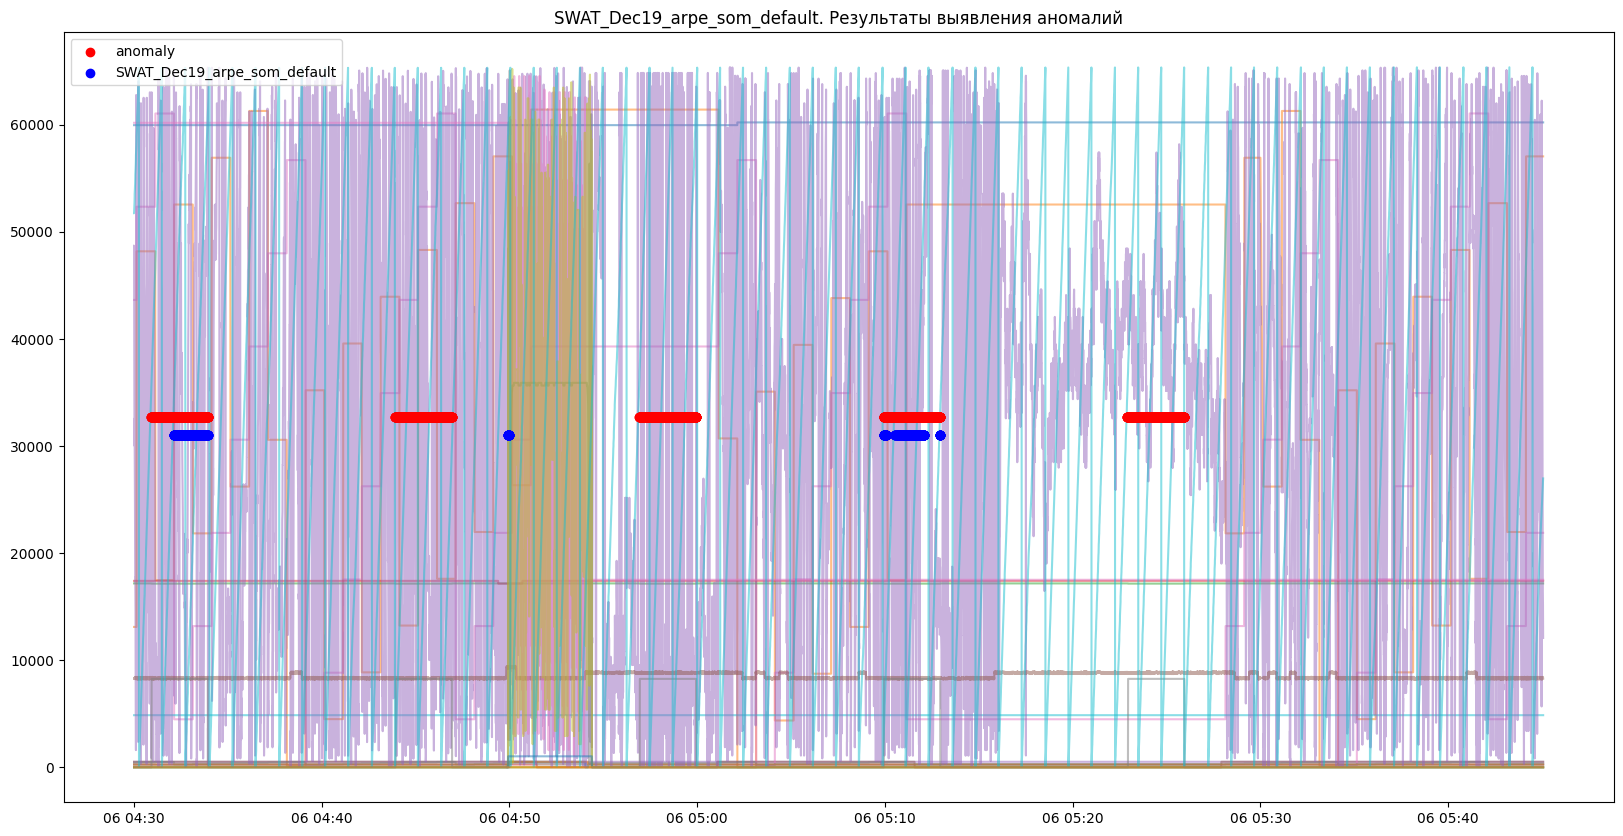

In [60]:
description = f'SWAT_Dec19_arpe_som_default'

model = SOM(x_train)

predictor = Predictor(model, 
                      [x_train, x_test, y_test], 
                      descr=description,
                      resave_model=False)

y_pred = predictor.get_anomalies()
summary[description] = predictor.get_score()
plot_result(df_test, y_test, y_pred, descr=description)

IntProgress(value=0, description='Computing', max=30002, style=ProgressStyle(bar_color='#61dc8a'))

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceed

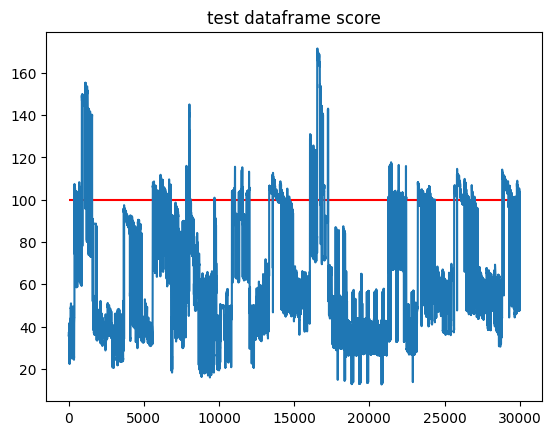

(30002,)
SWAT_Dec19_arpe_som_default
f1_score: 0.48
accuracy_score: 0.80
precision_score: 0.49
recall_score: 0.47


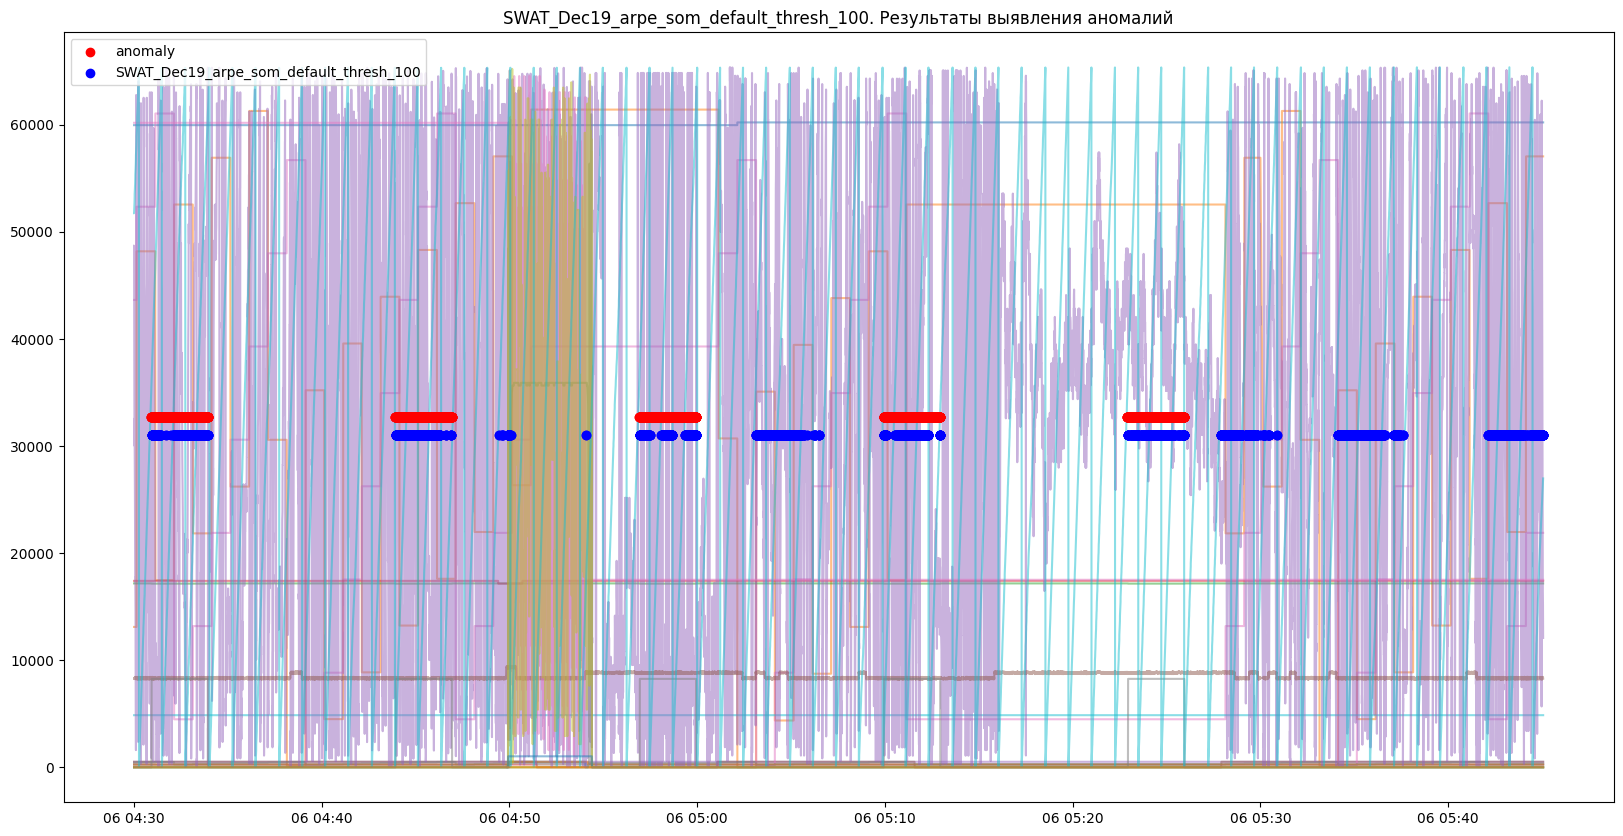

In [61]:
threshold=100

y_pred = predictor.get_anomalies(threshold=threshold)
summary[f'{description}_thresh_{threshold}'] = predictor.get_score()
plot_result(df_test, y_test, y_pred, descr=f'{description}_thresh_{threshold}')

# Сводная таблица

In [62]:
def highlight_max(s, props=''):
    return np.where(s == np.nanmax(s.values), props, '')

df_summary = pd.DataFrame(summary).T
df_summary.style.background_gradient(cmap='Blues')